In [2]:
##nodejs:  https://docs.aws.amazon.com/sdk-for-javascript/v2/developer-guide/setting-up-node-on-ec2-instance.html
import os
import sys

import pandas as pd
import numpy as np
import pickle
from datetime import date, datetime, timedelta

from category_encoders import OneHotEncoder
import xgboost as xgb

import boto3
import logging 

logger = logging.getLogger()
logging.basicConfig(level=logging.INFO)
logger.info(f'Starting Notebook')

# !pip install "jupyterlab>=3" "ipywidgets>=7.6" --user
# !pip install jupyter-dash --user
# !jupyter lab build --user

# !pip install snowflake --user
# !pip install snowflake-connector-python --user
import os
import sys
path=!pwd
sys.path.append(os.path.join(path[0], '..'))
from utils import *
import snowflake.connector

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_PROD","DATASCIENCE_STAGE")
cur = ctx.cursor()

INFO:root:Starting Notebook
Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
INFO:snowflake.connector.connection:Snowflake Connector for Python Version: 2.7.4, Python Version: 3.6.13, Platform: Linux-4.14.252-131.483.amzn1.x86_64-x86_64-with-glibc2.9
INFO:snowflake.connector.connection:This connection is in OCSP Fail Open Mode. TLS Certificates would be checked for validity and revocation status. Any other Certificate Revocation related exceptions or OCSP Responder failures would be disregarded in favor of connectivity.


In [9]:
from io import StringIO
class Utils():
    @staticmethod
    def to_csv_s3(content, bucket, key_path, filename):
        client = boto3.client('s3')
        key = os.path.join(key_path, filename)
        csv_buffer = StringIO()
        content.to_csv(csv_buffer)
        client.put_object(Bucket=bucket, Key=key, Body=csv_buffer.getvalue())
        logger.info(f'Saved to {bucket}/{key}')
    
    @staticmethod
    def to_pkl_s3(content, bucket, key_path, filename):
        client = boto3.client('s3')
        key = os.path.join(key_path, filename)
        obj = pickle.dumps(content)
        client.put_object(Bucket=bucket, Key=key, Body=obj)
        logger.info(f'Saved model to {os.path.join(bucket, key)}')
        logger.info(f'Saved to {bucket}/{key}')

    @staticmethod
    def read_csv_s3(bucket, key_path,filename):
        client = boto3.client('s3')
        key = os.path.join(key_path, filename)
        obj = client.get_object(Bucket=bucket, Key=key)
        df = pd.read_csv(obj['Body'], na_values="\\N")
        logger.info(f'Read from {bucket}/{key}')
        return df
        
    @staticmethod
    def read_pkl_s3(bucket, key_path,filename):
        client = boto3.client('s3')
        key = os.path.join(key_path, filename)
        obj = client.get_object(Bucket=bucket, Key=key)
        body = obj['Body'].read()
        model = pickle.loads(body)
        logger.info(f'Read from {bucket}/{key}')
        return model


class BaseFeatureMunger():
    def __init__(self, df_in, df_imdb_munged, mode, date_run, feature_other):
        self.df_in = df_in
        self.df_imdb_munged = df_imdb_munged
        self.mode = mode
        self.date_run = date_run
        self.feature_other = feature_other
        self.clean_df()
        self.fill_missing_data()
        if mode=='train':
            self.filter_df()
        self.get_datetime_features()
        self.aggregate_df()
        self.merge_imdb_features()
        self.get_first_views()
        self.return_df()
        
    def return_df(self):
        col_base = ['title_id', 'title_name', 'season_number',
       'content_category', 'content_source', 'category',
       'tier', 'effective_start_date', 'request_date', 'first_views',
       'days_since_premiere', 'days_on_platform', 'start_year']
        col_title = ['tier','content_category','category','title_name', 'title_id','season_number',
                'effective_start_date', 'prequel_count', 'prequel_featured_count','first_views','first_views_log']
        if self.mode=='train':
            return self.df_in[col_base], self.df_in_title[col_title+self.feature_other]
        elif self.mode=='predict':
            return self.df_in_title[col_title+self.feature_other]

    def clean_df(self):
        logger.info(f'base_data shape: {self.df_in.shape}')
        logger.info(f'base_data null: {self.df_in.isnull().sum()}')
        self.df_in.columns= self.df_in.columns.str.lower()
        self.dic_dtype = {'season_number':int, 'tier':int}
        self.df_in = self.df_in.astype(self.dic_dtype)
        self.df_in['effective_start_date'] = pd.to_datetime(self.df_in['effective_start_date'])
        
    def fill_missing_data(self):
        self.df_in['content_category'] = self.df_in['content_category'].fillna('series')
        self.df_in.loc[self.df_in['category'].isin(['Specials']), 'content_category']='special'
        self.df_in.loc[self.df_in['category'].isin(['Popcorn','Pay 1 WB Theatricals','Scripted Features', 'Pay1']), 'content_category']='movies'
        self.df_in.loc[self.df_in['title_name'].str.contains('Harry Potter'), 'content_category']='special'
        self.df_in = self.df_in.fillna(0)

    def filter_df(self):
        self.date_max = datetime.strptime(self.date_run, '%Y-%m-%d')- timedelta(days=60)
        self.df_in = self.df_in[(self.df_in['effective_start_date']<=self.date_max)]

    def get_datetime_features(self):
        self.df_in['start_year'] = self.df_in['effective_start_date'].dt.year
        self.df_in['start_quarter'] = self.df_in['effective_start_date'].dt.quarter
        
    def aggregate_df(self):
        grpby_title= ['title_name', 'title_id','tier','content_category','category','season_number',
                'effective_start_date']
        self.df_in_title = self.df_in[grpby_title + ['first_views']].groupby(by=grpby_title).sum().reset_index()

    def merge_imdb_features(self):
        key_merge = ['title_name','season_number', 'content_category', 'category', 'tier', 'effective_start_date']
        
        self.df_in_title = self.df_in_title.merge(self.df_imdb_munged, 
                                         on= key_merge, how='left')
        logger.info(f'title imdb shape: {self.df_in_title.shape}')
#         logger.info(f'title imdb features null: {self.df_in_title.isnull().sum()}')
        self.df_in_title = self.df_in_title.fillna(0)
        
    def get_first_views(self):
        ## Scale first_views 
        self.df_in_title['first_views_log'] = np.log(self.df_in_title['first_views']) 
        self.df_in_title.loc[(self.df_in_title.first_views==0), 'first_views_log']=0
        

        
    
    
class XGB(Utils):
    def __init__(self, df_in, mode, date_run, feature_cat, feature_cont):
        self.df_in = df_in    
        self.mode = mode
        self.date_run = date_run
        self.feature_cat_in = feature_cat
        self.feature_cont_in = feature_cont
        self.get_parameters()
        
        if mode=='train':
            self.train_xgb()
            self.save_model()
        elif mode=='predict':
            self.get_model()
            self.predict_xgb()
            self.return_df()
            
    @staticmethod
    def _encode(df, categoricals):
        
        """
        perform category encoding on the data
        :param df: dataframe to be encoded
        :param categoricals: list of name of categorical columns
        :return ohe, x_ohe: OHE object and OHE-encoded data
        """
        ohe = OneHotEncoder(cols=categoricals, 
                            handle_unknown='return_nan',
                           handle_missing='return_nan',  
                           use_cat_names=True) 
        x_ohe = ohe.fit_transform(df)
        return ohe, x_ohe
    
    def return_df(self):
        return self.df_pred
    
    def get_parameters(self):
        self.target = 'first_views_log'
        self.features_cat=['tier_adj','category','content_category','prequel_count'] + self.feature_cat_in
        self.features_cont= ['prequel_featured_count']+self.feature_cont_in
#         self.features_cont=['prequel_featured_count','page_views']
#         self.features_cont=['prequel_featured_count','award_name','page_views']
        self.param_xgb = {"booster":"gbtree",
                     "objective":"reg:squarederror",
                    "gamma":1,
                    "seed":1}

    def train_xgb(self):
        x_train = self.df_in[self.features_cat + self.features_cont]
        y_train = self.df_in[self.target]
        self.ohe, x_ohe = self._encode(x_train, self.features_cat)
        dm_train = xgb.DMatrix(x_ohe, label=y_train)

        ## train 
        self.model = xgb.train(params = self.param_xgb, dtrain = dm_train, num_boost_round = 10)
        
    def save_model(self):
        dict_model = {'model': self.model, 'ohe': self.ohe}
        Utils.to_pkl_s3(dict_model, input_bucket, key_path, f'fv_{date_train}.pkl')
        logger.info(f'Done model training {date_train}')
    
    def get_model(self):
        dict_model = Utils.read_pkl_s3(input_bucket, key_path, f'fv_{date_train}.pkl')
        self.ohe = dict_model['ohe']
        self.model = dict_model['model']
        
    def predict_xgb(self):
        x_test = self.df_in[self.features_cat + self.features_cont]
        x_ohe_test = self.ohe.transform(x_test)
        dm_test = xgb.DMatrix(x_ohe_test)
        pred = self.model.predict(dm_test)

        self.df_pred = self.df_in[list(set(['title_name','category','season_number', 'effective_start_date', 'tier','tier_adj'] + self.features_cat + self.features_cont))]
        self.df_pred['first_views_log_pred'] = pred
        self.df_pred[f'first_views_pred'] = np.exp(self.df_pred[f'first_views_log_pred'])
        self.df_pred['pred_date'] = self.date_run
        self.df_pred['pred_date'] = pd.to_datetime(self.df_pred['pred_date'])
        self.df_pred.loc[(self.df_pred.category=='Popcorn') & (self.df_pred.effective_start_date>='2022-04-01'), 'category']='Pay 1 WB Theatricals'


class FVDecay():
    def __init__(self, df_in, mode, date_run, grpby=''):
        self.df_in = df_in    
        self.mode = mode
        self.date_run = date_run
        self.grpby = grpby

        if mode=='train':
            self.get_decay_data_title()
            self.get_decay_curve()
            self.return_df()

    def return_df(self):
        return self.df_decay
        
    @staticmethod
    def apply_decay_curve(df_in, df_decay, df_popcorn_decay):
        category_list_train = df_decay.category.unique().tolist()
        df_in['decay_category'] = df_in['category']
        df_in.loc[(~df_in['decay_category'].isin(category_list_train)) & (df_in['decay_category']!='Popcorn'), 'decay_category'] = 'Pay1'
        
        
        ## Apply decay to prediction 
        df_pred_decay = df_in.merge(df_decay[['category','days_since_premiere','first_views_pct']], 
                                                left_on=['decay_category'], right_on=['category'], how='left', suffixes=['', '_category'])\
                            .merge(df_popcorn_decay[['category','days_since_premiere','first_views_pct']], 
                                        on=['category','days_since_premiere'], how='left', suffixes=['', '_popcorn'])
        print(df_pred_decay.columns)
        df_pred_decay.loc[(df_pred_decay.category=='Popcorn') & (df_pred_decay.first_views_pct.isnull()), 'first_views_pct'] = df_pred_decay['first_views_pct_popcorn']
        
        df_pred_decay[f'first_views_pred_decay'] = df_pred_decay[f'first_views_pred'] * df_pred_decay['first_views_pct']
        df_pred_decay['start_month'] = df_pred_decay['effective_start_date'].dt.to_period('M').dt.to_timestamp()
        df_pred_decay['request_date'] = df_pred_decay['effective_start_date'] + pd.to_timedelta(df_pred_decay.days_since_premiere, unit="D")
        df_pred_decay['first_view_quarter'] = df_pred_decay['request_date'].dt.to_period('Q').dt.to_timestamp()
        df_pred_decay['first_view_month'] = df_pred_decay['request_date'].dt.to_period('M').dt.to_timestamp()

        return df_pred_decay
    
    def get_decay_data_title(self):
        self.key_col = ['title_name','tier','content_category','category','season_number','effective_start_date']
        self.df_in = self.df_in[self.key_col + ['title_id','days_since_premiere','first_views']].sort_values(by=self.key_col+['days_since_premiere'])
        self.df_in['first_views_sum'] = self.df_in.groupby(self.key_col)['first_views'].transform('sum')
        self.df_in['first_views_cumsum'] = self.df_in.groupby(by=self.key_col)['first_views'].cumsum()
        self.df_in['first_views_cumpct'] = self.df_in['first_views_cumsum'] / self.df_in['first_views_sum']
        self.df_in.reset_index(inplace=True)
            
    def get_decay_curve(self):
        self.df_decay = self.df_in[[self.grpby] + ['title_id','days_since_premiere','first_views_cumpct']].sort_values(by=[self.grpby]+['days_since_premiere'])
        self.df_decay = self.df_decay.groupby(by=[self.grpby] + ['days_since_premiere']).agg({'first_views_cumpct':'median','title_id':'nunique'})
        self.df_decay = self.df_decay.rename(columns={'title_id':'title_count_training'})
        self.df_decay = self.df_decay.reset_index()
        self.df_decay['first_views_pct'] = self.df_decay.groupby(self.grpby)['first_views_cumpct'].diff()
        self.df_decay.reset_index(inplace=True)
        
        self.df_decay['days_since_premiere'] = self.df_decay['days_since_premiere'].astype(int)
        self.df_decay.loc[(self.df_decay.days_since_premiere==0),'first_views_pct'] = self.df_decay['first_views_cumpct']
        

class IMDBFeatureMunger(BaseFeatureMunger):
    
    def __init__(self, df_in, mode, date_run):
        self.df_in = df_in
        self.date_run = date_run 
        
        self.clean_df()
        if mode=='train':
            self.filter_df()
        self.get_series_features()
#         if mode=='train':
#             self.adjust_series_for_training_data()
        self.get_non_series_prequel_features()
        self.get_non_series_prequel_ref_features()
        self.merge_non_series_features()
        self.return_df()
        
    def return_df(self):
        col_imdb = ['title_name', 'season_number', 'content_category', 'category', 
                    'tier', 'effective_start_date', 'prequel_count', 'prequel_featured_count']
        self.df_imdb_munged = pd.concat([self.df_series_title, self.df_nseries_title])
#         self.df_imdb_munged = self.df_nseries_title.copy()
        self.df_imdb_munged = self.df_imdb_munged[col_imdb].groupby(by=col_imdb[:-2]).sum().reset_index()
        return self.df_imdb_munged
    
    def get_series_features(self):
        grpby_series = ['title_name','season_number','content_category','category','tier','effective_start_date']
        self.df_series = self.df_in[(self.df_in.content_category.isin(['series'])) & (self.df_in.reference_type.isin(['featured_in']))] 
        self.df_series_title = self.df_series.groupby(by=grpby_series).agg({'reference_title_id':'nunique'}).reset_index()
        self.df_series_title = self.df_series_title.rename(columns={'reference_title_id':'ref_ref_featured_in'})
#         self.df_series_title[['ref_follows','ref_spin_off_from','ref_remake_of']] = 0
        self.df_series_title['prequel_count'] = self.df_series_title['season_number']-1
        self.df_series_title['prequel_featured_count'] = self.df_series_title['ref_ref_featured_in']

    def adjust_series_for_training_data(self):     
        self.df_series_title['ref_ref_featured_in'] = (self.df_series_title['ref_ref_featured_in'] * (self.df_series_title['season_number']-1))/self.df_series_title['season_number']
        self.df_series_title.loc[self.df_series_title.season_number>1, 'prequel_featured_count'] = (self.df_series_title['ref_ref_featured_in'])/(self.df_series_title['season_number']-1)     
        
    def get_non_series_prequel_features(self):
        self.grpby_nseries=['title_name','season_number','content_category','category','tier','effective_start_date','imdb_imdb_series_id']
#         self.df_nseries = self.df_in[(self.df_in.content_category!='series')\
#                              & (self.df_in.reference_type.isin(['follows','spin_off_from','remake_of','version_of']))] 
        self.df_nseries = self.df_in[(self.df_in.reference_type.isin(['follows','spin_off_from','remake_of','version_of'])) & ((self.df_in.reference_title_type.isin(['movie','tvSeries'])))] 
        self.df_nseries['ref_ref_count'] = self.df_nseries.groupby('reference_title_id').reference_reference_title_id.transform('nunique')
        self.df_nseries = self.df_nseries[self.df_nseries['ref_ref_count']>0] ## Only count references that have secondary references 
        
        self.df_nseries_preq = self.df_nseries.groupby(by=self.grpby_nseries+['reference_type']).agg({'reference_title_id':'nunique'}).reset_index()
#         display(self.df_nseries_preq[self.df_nseries_preq.title_name=='House Of The Dragon'])
#         display(self.df_nseries[self.df_nseries.title_name=='House Of The Dragon'])
#         display(self.df_nseries_preq[self.df_nseries_preq.title_name=='House Of The Dragon'].head())
        self.df_nseries_preq = pd.pivot_table(self.df_nseries_preq, 
                          index = self.grpby_nseries, 
                          columns = 'reference_type', 
                          values = 'reference_title_id').reset_index()
 
        self.df_nseries_preq = self.df_nseries_preq.rename(columns={'follows':'ref_follows',  
                                                                          'spin_off_from':'ref_spin_off_from', 
                                                                          'remake_of':'ref_remake_of',
                                                                          'version_of':'ref_version_of'})
        
        
    def get_non_series_prequel_ref_features(self):
        self.df_nseries_preq_ref = self.df_nseries.groupby(by=self.grpby_nseries+['reference_reference_type']).agg({'reference_reference_title_id':'nunique'}).reset_index()
#         display(self.df_nseries_preq_ref[self.df_nseries_preq_ref.title_name=='The Matrix Resurrections'])
        self.df_nseries_preq_ref = pd.pivot_table(self.df_nseries_preq_ref, 
                  index = self.grpby_nseries, 
                  columns = 'reference_reference_type', 
                  values = 'reference_reference_title_id').reset_index()        
        self.df_nseries_preq_ref = self.df_nseries_preq_ref.rename(columns={'featured_in':'ref_ref_featured_in'})
        
    def merge_non_series_features(self):
        col_preq = ['title_name', 'tier','season_number','content_category','category','effective_start_date','imdb_imdb_series_id','ref_follows','ref_spin_off_from','ref_remake_of', 'ref_version_of']
        col_ref_ref = ['title_name','season_number','category','ref_ref_featured_in']
        self.df_nseries_title = self.df_nseries_preq[col_preq].merge(self.df_nseries_preq_ref[col_ref_ref], how='outer', on=['title_name','season_number','category'])
        self.df_nseries_title['prequel_count'] = self.df_nseries_title[['ref_follows','ref_spin_off_from','ref_remake_of','ref_version_of']].sum(axis=1)
        self.df_nseries_title['prequel_featured_count'] = self.df_nseries_title['ref_ref_featured_in']/self.df_nseries_title['prequel_count']
#         display(self.df_nseries_title[self.df_nseries_title.title_name=='House Of The Dragon'])
# mode='train'
# df_imdb = Utils.read_csv_s3(input_bucket, key_path, f'fv_train_imdb_{date_train}.csv')

# ## Munge features, get decay curves, resample  
# # df_imdb_munged = IMDBFeatureMunger(df_imdb, mode, date_train).df_imdb_munged

# mode='predict'
# df_imdb = Utils.read_csv_s3(input_bucket, key_path, f'fv_pred_{date_train}.csv')

# ## Munge features, get decay curves, resample  
# df_imdb_munged = IMDBFeatureMunger(df_imdb, mode, date_train).df_imdb_munged
# df_imdb_munged[df_imdb_munged.title_name=='Succession']

     
        
class PreProcessor():
    def __init__(self, df_in, mode, date_run):
        self.df_in = df_in
        self.date_run = date_run
        self.get_parameters()
        self.adjust_tiers()
#         self.winsorize_features()
        
        if mode=='train':
            self.winsorize_label()
            self.resample_data()
        self.return_df()
        
    def return_df(self):
        return self.df_in
    
    def get_parameters(self):
        self.max_firstviews = 1000000
        self.old_sampling_rate = 0.4
        self.recent_sampling_rate = 0.6
        self.pay1_sampling_rate = 0.5
        
    def adjust_tiers(self):
        self.df_in['tier_adj'] = self.df_in['tier']
        self.df_in.loc[(self.df_in.title_name=='Reminiscence'), 'tier_adj'] = 2
        self.df_in.loc[(self.df_in.category=='Pay1') & (self.df_in.tier==1), 'tier_adj'] = 2
        self.df_in.loc[(self.df_in.category=='Pay1') & (self.df_in.tier==2), 'tier_adj'] = 3
        self.df_in.loc[(self.df_in.effective_start_date < '2022-04-01') & (self.df_in.category=='Popcorn') & (self.df_in.tier==1), 'tier_adj'] = 0

    def winsorize_label(self):
        self.df_in.loc[self.df_in.first_views>self.max_firstviews, 'first_views'] = self.max_firstviews
    
#     def winsorize_features(self):
        # winsorize season to 10
        # winsorize ref_tot to 5 
        # winsorize ref_ref tot to 20
        # Penalize kids & family 
        # for series future titles, nullify ref_ features to keep consistent 
#         self.df_in.loc[(self.df_in['prequel_count']>5), ['prequel_count']] = 5
#         self.df_in.loc[(self.df_in['prequel_featured_count']>20), ['prequel_featured_count']] = 20   
#         try:
#             self.df_in.loc[(self.df_in['prequel_count_s']>5), ['prequel_count_s']] = 5
#             self.df_in.loc[(self.df_in['prequel_featured_count_s']>10), ['prequel_featured_count_s']] = 10   
#         except:
#             pass
#         self.df_in.loc[(self.df_in.content_category=='series') & (self.df_in['prequel_count']>3), 'prequel_count'] = 3
#         self.df_in.loc[(self.df_in['category']=='Kids & Family'), ['prequel_featured_count']] = -1
#         self.df_in.loc[(self.df_in['tier']>=2), ['prequel_count']] = -1
#         self.df_in.loc[(self.df_in['tier']>=2), ['prequel_featured_count']] = -1
        
#         self.df_in.loc[(self.df_in.tier_adj>=2), self.df_in[['page_views','page_views_s','prequel_featured_count','prequel_featured_count_s']]] = -2
        
#         self.df_in.loc[(self.df_in.content_category=='movie'), self.df_in['page_views_s']] = -1
#         self.df_in.loc[(self.df_in.content_category!='movie'), self.df_in['page_views']] = -1
#         self.df_in.loc[(self.df_in.content_category=='movie'), self.df_in['prequel_featured_count_s']] = -1
#         self.df_in.loc[(self.df_in.content_category!='movie'), self.df_in['prequel_featured_count']] = -1
    
#         self.df_in['page_views']= pd.cut(self.df_in['page_views'], bins=page_views_bin,labels=[1,2,3,4])
        
        
#         page_views_bin = [-1, 1, 500000]  # -1: series, -2: low tier, 
#         page_views_s_bin = [-1, 1,500000]  # -1: movie, -2: low tier, 
#         prequel_featured_count_bin = [-1, 5, 30, ] # -1: series, -2: low tier, 
#         prequel_featured_count_bin_s = [-1, 5, 50] # -1: series, -2: low tier,
        
#         self.df_in.loc[(self.df_in.content_category=='series') & (self.df_in['prequel_count']>3), 'prequel_count'] = 3
        
    
    def resample_data(self):  
        self.df_in_old = self.df_in[(self.df_in.effective_start_date < datetime.strptime(self.date_run, '%Y-%m-%d')- timedelta(days=270))]
        self.df_in_recent = self.df_in[(self.df_in.effective_start_date >= datetime.strptime(self.date_run, '%Y-%m-%d')- timedelta(days=270))]
        target_count = self.df_in.groupby(by=['tier_adj','category'])['title_name'].count().max()
        print(target_count)
        target_count_old = int(round(target_count*self.old_sampling_rate))
        target_count_new = int(round(target_count*self.recent_sampling_rate))
        
        ## Loop through old and recent data
        df_resample_list = []
        for df_sample, target_count in zip([self.df_in_old, self.df_in_recent], [target_count_old, target_count_new]):
            list_tier_cat= df_sample[['tier_adj','category']].drop_duplicates(subset=['tier_adj','category']).values.tolist()
            
            ## Loop through unique combination of tier & category to resample 
            for tier_cat in list_tier_cat:
                if tier_cat[1]=='Pay1':
                    df_resample_list.append(df_sample[(df_sample.tier_adj==tier_cat[0]) & (df_sample.category==tier_cat[1])]\
                                        .sample(int(round(target_count*self.pay1_sampling_rate)), replace=True))                
                else:
                    df_resample_list.append(df_sample[(df_sample.tier_adj==tier_cat[0]) & (df_sample.category==tier_cat[1])]\
                                        .sample(target_count, replace=True))
        self.df_in = pd.concat(df_resample_list, axis=0)
      

In [ ]:
### df_imdb[(df_imdb.reference_type.isin(['follows','spin_off_from','remake_of','version_of'])) & (df_imdb.reference_title_type=='videoGame')]

In [78]:
reference_title_type

df_imdb[df_imdb.reference_type.isin(['follows','spin_off_from','remake_of','version_of'])].groupby(by='reference_title_type').count()

,unnamed: 0,title_name,imdb_imdb_series_id,season_number,tier,category,content_category,effective_start_date,schedule_label,imdb_title_name,n_votes,reference_type,reference_title,reference_title_id,reference_n_votes,reference_reference_type,reference_reference_title_id
reference_title_type,,,,,,,,,,,,,,,,,
movie,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900,3892,3892
short,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,46,46
tvEpisode,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,0,0
tvMiniSeries,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,14,14
tvMovie,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,0,0
tvSeries,2424,2424,2424,2424,2424,2424,2424,2424,2424,2424,2424,2424,2424,2424,2424,2350,2350
video,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,3,3
videoGame,340,340,340,340,340,340,340,340,340,340,340,340,340,340,340,337,337


In [11]:
display(df_imdb_munged[df_imdb_munged.tier==0])
df_imdb_munged[df_imdb_munged.tier==1]

,title_name,season_number,content_category,category,tier,effective_start_date,prequel_count,prequel_featured_count
25,DCU Green Lantern,1,series,Scripted Drama Series,0,2024-03-14,1.0,9.000000
31,Dune,0,movie,Popcorn,0,2021-10-22,2.0,27.500000
33,Euphoria,2,series,Scripted Drama Series,0,2022-01-09,1.0,9.000000
42,Godzilla vs. Kong,0,movie,Popcorn,0,2021-03-31,5.0,25.800000
56,House Of The Dragon,1,series,Scripted Drama Series,0,2022-08-21,1.0,369.000000
57,House Of The Dragon,2,series,Scripted Drama Series,0,2024-05-12,2.0,369.000000
86,Mortal Kombat,0,movie,Popcorn,0,2021-04-23,2.0,86.500000
119,Sisterhood of Dune,1,series,Scripted Drama Series,0,2024-04-25,1.0,19.000000
120,Space Jam: A New Legacy,0,movie,Popcorn,0,2021-07-16,1.0,58.000000
147,The Last Of Us,1,series,Scripted Drama Series,0,2023-01-15,1.0,100.000000


,title_name,season_number,content_category,category,tier,effective_start_date,prequel_count,prequel_featured_count
7,And Just Like That,1,series,Scripted Comedy Series,1,2021-12-09,3.0,46.000000
8,And Just Like That,2,series,Scripted Comedy Series,1,2023-06-08,4.0,46.000000
9,And Just Like That,3,series,Scripted Comedy Series,1,2024-10-03,5.0,46.000000
10,Austin Powers 4,0,movie,Scripted Features,1,2024-09-26,3.0,82.333333
15,Beetlejuice 2,0,movie,Scripted Features,1,2023-10-26,1.0,93.000000
16,Black Adam,0,movie,Popcorn,1,2022-12-05,1.0,27.000000
30,Dune,0,movie,Pay1,1,2022-03-10,2.0,27.500000
32,Dune: Part Two,0,movie,Popcorn,1,2023-12-04,1.0,19.000000
34,Euphoria,3,series,Scripted Drama Series,1,2023-11-12,2.0,9.000000
36,F9: The Fast Saga,0,movie,Pay1,1,2022-03-04,8.0,30.250000


In [4]:
date_train='2022-04-01'

dic_key_path = {'prod':'psi_first_views/dev', 'backtest':'psi_first_views/dev'}
input_bucket="hbo-ingest-datascience-content-dev"
output_bucket="hbo-outbound-datascience-content-dev"

prod_backtest = 'prod' ## 'prod', 'backtest'
key_path = dic_key_path[prod_backtest]

In [6]:
## wiki view 
querystr = '''
with psi_past_base_assets_title as 
    (select 
          title_id
        , coalesce(season_number,0) as season_number
        , title_name
        , content_category
        , program_type
        , category
        , tier
        , effective_start_date
        , effective_end_date
    from max_dev.workspace.psi_past_base_assets
    group by 1,2,3,4,5,6,7,8,9
    )
select 
        pba.title_id
        , coalesce(pba.season_number,0) as season_number
        , pba.title_name
        , pba.content_category
        , pba.program_type
        , pba.category
        , pba.tier
        , pba.effective_start_date
        , pba.effective_end_date
        , itc.name_id
        , itc.contributor_name
        , itc.category as talent_category
//      , itc.known_for
//      , itc.credits_by_category
//      , itc.principal_cast_member
//      , itc.principal_crew_member
      , itc.billing_order
      , itc.listing_order
      , wpv.date
      , wpv.page_views
//      , sum(wpv.page_views) as page_views
from max_dev.workspace.psi_past_base_assets pba
left join max_prod.editorial.imdb_viewable_map ivm
    on pba.title_id = coalesce(ivm.viewable_id, ivm.viewable_series_id) 
left join max_prod.ckg.imdb_title_contributor itc
    on coalesce(ivm.imdb_id, ivm.imdb_series_id) = itc.title_id
left join max_prod.ckg.id_mapping_imdb_wikipedia  miw
    on miw.imdb_id = itc.name_id
left join max_prod.ckg.wikipedia_page_views wpv
    on miw.wikipedia_article = wpv.wikipedia_article
where 
itc.category in ('director', 'writer','cast') 
and itc.listing_order <=3
and miw.language='en'
and wpv.language='en'
and wpv.wikipedia_site='en'
and wpv.date>='2020-01-01'
// group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14 
'''

cursor_list = ctx.execute_string(
    querystr
    )
df_talent = pd.DataFrame.from_records(cursor_list[-1].fetchall(), columns=[x[0] for x in cursor_list[-1].description])
df_talent.columns= df_talent.columns.str.lower()
display(df_talent.head())

df_talent = df_talent.fillna(0)
print(df_talent.columns)

df_talent['date'] = pd.to_datetime(df_talent['date'])
df_talent['effective_start_date'] = pd.to_datetime(df_talent['effective_start_date'])
df_pv = df_talent[(df_talent.date<=df_talent.effective_start_date) & (df_talent.date>=(df_talent.effective_start_date - timedelta(days=90)))]
grpby = ['title_id', 'season_number', 'title_name', 'content_category',
       'program_type', 'category', 'tier', 'effective_start_date',
       'effective_end_date', 'name_id', 'contributor_name',
       'talent_category',  'listing_order'] 
df_pv = df_pv.drop_duplicates(subset=grpby[:-2]+['date'], keep='first')

df_pv_t = df_pv[grpby+['page_views']].groupby(by=grpby).sum().reset_index()
df_pv_t=df_pv_t.drop_duplicates(subset=grpby[:-2], keep='first')

df_pv_t = df_pv_t[df_pv_t.talent_category=='cast']
df_pv_title_pg = df_pv_t.sort_values(by=grpby[:-4]+['page_views'], ascending=False)
df_pv_title_pg = df_pv_title_pg.groupby(by=grpby[:-4]).head(3).reset_index(drop=True)
df_pv_title_pg = df_pv_title_pg.groupby(by=['title_id','title_name','season_number','content_category','category','tier']).sum().reset_index()
# df_pv_title_pg['page_views'] = np.log(df_pv_title_pg['page_views'])
df_pv_title_pg.loc[df_pv_title_pg.tier>1, 'page_views']=0
# df_pv_title_pg.loc[df_pv_title_pg.content_category=='series','page_views']=1
df_pv_title = df_pv_title_pg.copy()

Utils.to_csv_s3(df_pv_title, input_bucket, key_path, f'pgv_train_{date_train}.csv')


INFO:snowflake.connector.cursor:query: [with psi_past_base_assets_title as (select title_id , coalesce(season_number,0) ...]


KeyboardInterrupt: 

In [ ]:
## wiki view_pred 
querystr = '''
with psi_future_assets_title as 
    (select
      fp.title as title_name
    , fp.season as season_number
    , fp.tier
    , fp.category
    , fp.premiere_date as effective_start_date
    , fp.schedule_label
    from max_prod.content_analytics.daily_future_programming_schedule fp
    group by 1,2,3,4,5,6
    )
select 
    fp.title_name
    , fp.season_number
    , fp.tier
    , fp.category
    , ft.content_category
    , fp.effective_start_date
    , fp.schedule_label
    , ft.imdb_title_id
      , itc.name_id
      , itc.contributor_name
      , itc.category as talent_category
      , itc.billing_order
      , itc.listing_order
      , wpv.date
      , wpv.page_views
from psi_future_assets_title fp
left join max_dev.workspace.future_title_imdb_map ft
    on fp.title_name = ft.title_name and fp.season_number = ft.season_number and fp.category=ft.category
left join max_prod.ckg.imdb_title_contributor itc
    on ft.imdb_title_id = itc.title_id
left join max_prod.ckg.id_mapping_imdb_wikipedia  miw
    on miw.imdb_id = itc.name_id
left join max_prod.ckg.wikipedia_page_views wpv
    on miw.wikipedia_article = wpv.wikipedia_article
where 
itc.category in ('director', 'writer','cast') 
and itc.listing_order <=3
and miw.language='en'
and wpv.language='en'
and wpv.wikipedia_site='en'
and wpv.date>='2020-01-01'
'''

cursor_list = ctx.execute_string(
    querystr
    )
df_talent = pd.DataFrame.from_records(cursor_list[-1].fetchall(), columns=[x[0] for x in cursor_list[-1].description])
df_talent.columns= df_talent.columns.str.lower()
display(df_talent.head())

df_talent = df_talent.fillna(0)
print(df_talent.columns)


df_talent['date'] = pd.to_datetime(df_talent['date'])
df_talent['effective_start_date'] = pd.to_datetime(df_talent['effective_start_date'])
df_talent['tier']=df_talent['tier'].astype(int)
df_pv = df_talent[(df_talent.date<=df_talent.effective_start_date) & (df_talent.date>=(datetime.strptime(date_train, '%Y-%m-%d') - timedelta(days=90)))]
grpby = ['title_name', 'season_number',  'content_category',
       'category', 'tier', 'effective_start_date',
       'name_id', 'contributor_name',
       'talent_category',  'listing_order'] 
df_pv = df_pv.drop_duplicates(subset=grpby[:-2]+['date'], keep='first')

df_pv_t = df_pv[grpby+['page_views']].groupby(by=grpby).sum().reset_index()
df_pv_t=df_pv_t.drop_duplicates(subset=grpby[:-2], keep='first')

# df_pv_t = df_pv_t[df_pv_t.talent_category=='cast']
df_pv_title_pg = df_pv_t.sort_values(by=grpby[:-4]+['page_views'], ascending=False)
df_pv_title_pg = df_pv_title_pg.groupby(by=grpby[:-4]).head(3).reset_index(drop=True)
df_pv_title_pg = df_pv_title_pg.groupby(by=['title_name','season_number','content_category','category','tier']).sum().reset_index()
# df_pv_title_pg['page_views'] = np.log(df_pv_title_pg['page_views'])
df_pv_title_pg.loc[df_pv_title_pg.tier>1, 'page_views']=0
# df_pv_title_pg.loc[df_pv_title_pg.content_category=='series','page_views']=1
df_pv_title_pred = df_pv_title_pg.copy()
# df_pv_title_pred.isnull().sum()

Utils.to_csv_s3(df_pv_title_pred, input_bucket, key_path, f'pgv_pred_{date_train}.csv')


In [32]:
# df_pv_title = df_pv_title_pg.copy()
# display(df_pv_title.sort_values(by='award_name').tail(20))
# df_pv[df_pv.contributor_name=='Larry David']

1. cast wiki view (3, 6, 12 months prior to release) 
2. director and writer wiki view 
3. director and writer awards (3 years) 


In [35]:
df_in_train[df_in_train.tier_adj<=1].describe(percentiles=[0.05,0.1,0.25,0.5,0.75,0.8,0.85,0.9,0.95]) 

# page_views_bin = [-1, 1, 500000]  # -1: series, -2: low tier, 
# page_views_s_bin = [-1, 1,500000]  # -1: movie, -2: low tier, 
# prequel_featured_count_bin = [-1, 5, 30, ] # -1: series, -2: low tier, 
# prequel_featured_count_bin_s = [-1, 5, 50] # -1: series, -2: low tier, 

,tier,season_number,prequel_count,prequel_featured_count,first_views,first_views_log,prequel_featured_count_s,tier_adj,page_views,page_views_s,prequel_count_s
count,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,3.680000e+02,3.680000e+02,0.0
mean,0.668293,0.636585,0.065854,6.753496,426278.768293,12.620101,24.372764,0.585366,1.486145e+05,3.633418e+05,NaN
std,0.471402,0.789372,2.346105,22.205981,299310.358978,1.134209,62.648030,0.493261,2.683526e+05,4.234919e+05,NaN
min,0.000000,0.000000,-1.000000,-1.000000,119.000000,4.779123,-1.000000,0.000000,0.000000e+00,0.000000e+00,NaN
5%,0.000000,0.000000,-1.000000,-1.000000,84467.000000,11.344116,-1.000000,0.000000,0.000000e+00,0.000000e+00,NaN
10%,0.000000,0.000000,-1.000000,-1.000000,117410.000000,11.673427,-1.000000,0.000000,0.000000e+00,0.000000e+00,NaN
25%,0.000000,0.000000,-1.000000,-1.000000,172427.000000,12.057729,0.000000,0.000000,0.000000e+00,0.000000e+00,NaN
50%,1.000000,0.000000,-0.500000,-0.500000,334769.000000,12.721196,0.500000,1.000000,0.000000e+00,2.506810e+05,NaN
75%,1.000000,1.000000,0.000000,0.000000,727204.000000,13.496962,4.500000,1.000000,1.912780e+05,7.306290e+05,NaN
80%,1.000000,1.000000,0.000000,0.000000,727204.000000,13.496962,4.500000,1.000000,4.034220e+05,7.306290e+05,NaN


In [240]:
# df_pv_title = Utils.read_csv_s3(input_bucket, key_path, f'pgv_train_2022-04-01.csv')
# display(df_in_pred[(df_in_pred.page_views>=100000)  & (df_in_pred.page_views<200000)& (df_in_pred.content_category!='movies')].drop_duplicates())
# # display(df_pv_title[(df_pv_title.page_views>=100000) & (df_pv_title.content_category!='movies')])
# display(df_in_pred[(df_in_pred.page_views>=200000) & (df_in_pred.page_views<300000) & (df_in_pred.content_category!='movies')].drop_duplicates())
# display(df_in_pred[(df_in_pred.page_views>=300000) & (df_in_pred.content_category!='movies')].drop_duplicates())

# display(df_in_pred[(df_in_pred.page_views>=100000)  & (df_in_pred.page_views<200000)& (df_in_pred.content_category=='movies')].drop_duplicates())
# display(df_in_pred[(df_in_pred.page_views>=200000) & (df_in_pred.page_views<300000)& (df_in_pred.content_category=='movies')].drop_duplicates())
# display(df_in_pred[(df_in_pred.page_views>=300000) & (df_in_pred.content_category=='movies')].drop_duplicates())

# display(df_in_pred[(df_in_pred.tier_adj<2)  & (df_in_pred.prequel_featured_count_s>=0)  & (df_in_pred.prequel_featured_count_s<10)& (df_in_pred.content_category!='movies')].drop_duplicates())
# display(df_in_pred[(df_in_pred.prequel_featured_count_s>=10) & (df_in_pred.prequel_featured_count_s<30)& (df_in_pred.content_category!='movies')].drop_duplicates())
# display(df_in_pred[(df_in_pred.prequel_featured_count_s>=50) & (df_in_pred.content_category!='movies')].drop_duplicates())

display(df_in_pred[(df_in_pred.tier_adj<2)  & (df_in_pred.prequel_featured_count>=0)  & (df_in_pred.prequel_featured_count<10)& (df_in_pred.content_category=='movies')].drop_duplicates())
display(df_in_pred[(df_in_pred.prequel_featured_count>=10) & (df_in_pred.prequel_featured_count<30)& (df_in_pred.content_category=='movies')].drop_duplicates())
display(df_in_pred[(df_in_pred.prequel_featured_count>=50) & (df_in_pred.content_category=='movies')].drop_duplicates())


# display(df_in_train[df_in_train.title_name.isin(['Euphoria','Succession'])].sort_values(by='content_category').drop_duplicates())
# display(df_imdb_munged[df_imdb_munged.title_name.isin(['Euphoria','Succession'])].sort_values(by='content_category').drop_duplicates())

,tier,content_category,category,title_name,title_id,season_number,effective_start_date,prequel_count,prequel_featured_count,first_views,first_views_log,prequel_featured_count_s,tier_adj,page_views,page_views_s
2,1,movies,Popcorn,2023 WB Event Film #1,0,0,2023-02-27,0.0,0.0,0,0.0,0.0,1,NaN,NaN
3,1,movies,Popcorn,2023 WB Event Film #2,0,0,2023-08-21,0.0,0.0,0,0.0,0.0,1,NaN,NaN
9,1,movies,Scripted Features,A Christmas Story Christmas,0,0,2022-11-17,0.0,0.0,0,0.0,0.0,1,39615.0,39615.0
28,1,movies,Popcorn,Aquaman and the Lost Kingdom,0,0,2023-05-15,0.0,0.0,0,0.0,0.0,1,NaN,NaN
29,1,movies,Scripted Features,Austin Powers 4,0,0,2024-09-26,0.0,0.0,0,0.0,0.0,1,147306.0,147306.0
31,1,movies,Popcorn,Barbie,0,0,2024-02-08,0.0,0.0,0,0.0,0.0,1,679624.0,679624.0
35,1,movies,Scripted Features,Batgirl (DC),0,0,2023-07-20,0.0,0.0,0,0.0,0.0,1,468125.0,468125.0
39,1,movies,Scripted Features,Beetlejuice 2,0,0,2023-10-26,0.0,0.0,0,0.0,0.0,1,198390.0,198390.0
43,1,movies,Popcorn,Black Adam,0,0,2022-12-05,0.0,0.0,0,0.0,0.0,1,774991.0,774991.0
44,1,movies,Scripted Features,Black Canary,0,0,2024-03-15,0.0,0.0,0,0.0,0.0,1,68979.0,68979.0


,tier,content_category,category,title_name,title_id,season_number,effective_start_date,prequel_count,prequel_featured_count,first_views,first_views_log,prequel_featured_count_s,tier_adj,page_views,page_views_s


,tier,content_category,category,title_name,title_id,season_number,effective_start_date,prequel_count,prequel_featured_count,first_views,first_views_log,prequel_featured_count_s,tier_adj,page_views,page_views_s


In [258]:
# df_pv_title = Utils.read_csv_s3(input_bucket, key_path, f'pgv_train_2022-04-01.csv')
# display(df_in_train[(df_in_train.page_views>=100000)  & (df_in_train.page_views<200000)& (df_in_train.content_category!='movies')].drop_duplicates())
# # display(df_pv_title[(df_pv_title.page_views>=100000) & (df_pv_title.content_category!='movies')])
# display(df_in_train[(df_in_train.page_views>=200000) & (df_in_train.content_category!='movies')].drop_duplicates())
# display(df_in_train[(df_in_train.page_views>=300000) & (df_in_train.content_category!='movies')].drop_duplicates())

# display(df_in_train[(df_in_train.page_views>=100000)  & (df_in_train.page_views<200000)& (df_in_train.content_category=='movies')].drop_duplicates())
# display(df_in_train[(df_in_train.page_views>=200000) & (df_in_train.page_views<300000)& (df_in_train.content_category=='movies')].drop_duplicates())
# display(df_in_train[(df_in_train.page_views>=300000) & (df_in_train.content_category=='movies')].drop_duplicates())

display(df_in_train[(df_in_train.tier_adj<2)  & (df_in_train.prequel_featured_count_s>=0)  & (df_in_train.prequel_featured_count_s<10)& (df_in_train.content_category!='movies')].drop_duplicates())
display(df_in_train[(df_in_train.prequel_featured_count_s>=10) & (df_in_train.prequel_featured_count_s<30)& (df_in_train.content_category!='movies')].drop_duplicates())
display(df_in_train[(df_in_train.prequel_featured_count_s>=50) & (df_in_train.content_category!='movies')].drop_duplicates())

# display(df_in_train[(df_in_train.tier_adj<2)  & (df_in_train.prequel_featured_count>=0)  & (df_in_train.prequel_featured_count<10)& (df_in_train.content_category=='movies')].drop_duplicates())
# display(df_in_train[(df_in_train.prequel_featured_count>=10) & (df_in_train.prequel_featured_count<30)& (df_in_train.content_category=='movies')].drop_duplicates())
# display(df_in_train[(df_in_train.prequel_featured_count>=50) & (df_in_train.content_category=='movies')].drop_duplicates())


# display(df_in_train[df_in_train.title_name.isin(['Euphoria','Succession'])].sort_values(by='content_category').drop_duplicates())
# display(df_imdb_munged[df_imdb_munged.title_name.isin(['Euphoria','Succession'])].sort_values(by='content_category').drop_duplicates())

,tier,content_category,category,title_name,title_id,season_number,effective_start_date,prequel_count,prequel_featured_count,first_views,first_views_log,prequel_featured_count_s,tier_adj,page_views,page_views_s
534,1,series,Scripted Comedy Series,Love Life,GXrxUzQ5VqrGGtAEAAAAd,1,2020-05-27,0.0,3.0,242346,12.398122,3.0,1,277685.0,277685.0
558,1,series,Scripted Drama Series,Lovecraft Country,GXqxXjAFASIC9JwEAAALh,1,2020-08-17,0.0,1.0,293754,12.590498,1.0,1,102815.0,102815.0
559,1,series,Scripted Drama Series,Raised by Wolves,GX0WFcAlf5r5cuAEAAADu,1,2020-09-03,0.0,1.0,360230,12.794498,1.0,1,NaN,NaN
561,1,series,Scripted Drama Series,Mare of Easttown,GYCiC1Q8picLCfAEAAAAC,1,2021-04-19,0.0,0.0,184357,12.124629,0.0,1,NaN,NaN
562,1,series,Scripted Drama Series,The Undoing,GX0aOXAiLMxTCwwEAAANL,1,2020-10-26,0.0,5.0,420654,12.949566,5.0,1,403139.0,403139.0
606,0,series,Scripted Drama Series,The Flight Attendant,GX5MHsQzwwIuLwgEAAACp,1,2020-11-26,0.0,3.0,758838,13.539544,3.0,0,278616.0,278616.0
881,1,series,Scripted Comedy Series,Love Life,GXrxUzQ5VqrGGtAEAAAAd,2,2021-10-28,1.0,3.0,6738,8.815518,3.0,1,208642.0,208642.0
882,1,series,Scripted Comedy Series,The Sex Lives of College Girls,GYXBzKw3n5aJmOwEAAAAE,1,2021-11-18,0.0,0.0,84467,11.344116,0.0,1,105069.0,105069.0
1066,0,series,Scripted Drama Series,Euphoria,GXKN_xQX5csPDwwEAAABj,2,2022-01-10,1.0,9.0,727204,13.496962,9.0,0,1357397.0,1357397.0
1159,1,series,Scripted Drama Series,The Gilded Age,GYZLijQsvoJKWWQEAAAB6,1,2022-01-25,0.0,0.0,123190,11.721483,0.0,1,NaN,NaN


,tier,content_category,category,title_name,title_id,season_number,effective_start_date,prequel_count,prequel_featured_count,first_views,first_views_log,prequel_featured_count_s,tier_adj,page_views,page_views_s
388,2,series,Unscripted Series,Last Week Tonight with John Oliver,GVU2cCgUFTYNJjhsJATuH,8,2021-02-15,7.0,25.0,43147,10.672368,25.0,2,0.0,0.0
1158,1,series,Scripted Drama Series,Peacemaker,GYb0FKQLsGIyPfQEAAAAM,1,2022-01-13,1.0,15.0,172427,12.057729,15.0,1,272782.0,272782.0
1160,1,series,Scripted Drama Series,Succession,GWukCJAq-nIuHwwEAAAB4,3,2021-10-18,2.0,13.0,160562,11.986435,13.0,1,231289.0,231289.0


,tier,content_category,category,title_name,title_id,season_number,effective_start_date,prequel_count,prequel_featured_count,first_views,first_views_log,prequel_featured_count_s,tier_adj,page_views,page_views_s
157,3,series,Kids & Family,Sesame Street,GXouLWwp8MsPDIgEAAAqT,13,2020-11-01,19.0,143.142857,21,3.044522,143.142857,3,0.0,0.0
161,3,series,Kids & Family,Sesame Street,GXouLWwp8MsPDIgEAAAqT,45,2020-11-01,51.0,143.142857,713,6.569481,143.142857,3,0.0,0.0
164,3,series,Kids & Family,Sesame Street,GXouLWwp8MsPDIgEAAAqT,47,2020-11-01,53.0,143.142857,961,6.867974,143.142857,3,0.0,0.0
166,3,series,Kids & Family,Sesame Street,GXouLWwp8MsPDIgEAAAqT,35,2020-11-01,41.0,143.142857,80,4.382027,143.142857,3,0.0,0.0
167,3,series,Kids & Family,Sesame Street,GXouLWwp8MsPDIgEAAAqT,43,2020-11-01,49.0,143.142857,523,6.259581,143.142857,3,0.0,0.0
168,3,series,Kids & Family,Sesame Street,GXouLWwp8MsPDIgEAAAqT,46,2020-11-01,52.0,143.142857,951,6.857514,143.142857,3,0.0,0.0
172,3,series,Kids & Family,Adventure Time: Distant Lands,GXuu7ygQ61cI9DgEAAAAY,1,2020-06-25,1.0,132.000000,34932,10.461159,132.000000,3,0.0,0.0
173,3,series,Kids & Family,Sesame Street,GXouLWwp8MsPDIgEAAAqT,42,2020-11-01,48.0,143.142857,479,6.171701,143.142857,3,0.0,0.0
176,3,series,Kids & Family,Sesame Street,GXouLWwp8MsPDIgEAAAqT,44,2020-11-01,50.0,143.142857,335,5.814131,143.142857,3,0.0,0.0
336,0,special,Specials,Friends: The Reunion,GYJxCDACcN8PDewEAAAAG,0,2021-05-27,1.0,253.000000,867875,13.673803,253.000000,0,808410.0,808410.0


In [15]:
from io import StringIO

feature=['page_views','page_views_s']
feature_other= ['prequel_featured_count_s']
feature_cont = ['prequel_featured_count_s']
feature_cat = ['page_views','page_views_s']

# feature= [] #['page_views','page_views_s']
# feature_other= []# ['prequel_featured_count_s']
# feature_cont = []#['prequel_featured_count_s']
# feature_cat = []#['page_views','page_views_s']

dic_key_path = {'prod':'psi_first_views/dev', 'backtest':'psi_first_views/dev'}
input_bucket="hbo-ingest-datascience-content-dev"
output_bucket="hbo-outbound-datascience-content-dev"

prod_backtest = 'prod' ## 'prod', 'backtest'
key_path = dic_key_path[prod_backtest]

if prod_backtest =='prod':
#     list_date_train = [(datetime.today()).strftime('%Y-%m-%d')]
    list_date_train=['2022-04-01']
elif prod_backtest =='backtest':
    list_date_train =['2021-10-01','2021-11-01','2021-12-01','2022-01-01'] #['2021-01-01', '2021-02-01', '2021-03-01','2021-04-01', '2021-05-01', '2021-06-01','2021-07-01', '2021-08-01', '2021-09-01']

df_pred_list = []
df_pred_decay_list = [] 
for date_train in list_date_train:
    date_pred = date_train 
    print(date_pred)
   
    #### Train 
    mode = 'train'
    logger.info(f'TRAINING MODEL FOR {date_train}, Mode:{prod_backtest}')
    
    ## Read data 
    df_raw = Utils.read_csv_s3(input_bucket, key_path, f'fv_train_fv_{date_train}.csv')
    df_imdb = Utils.read_csv_s3(input_bucket, key_path, f'fv_train_imdb_{date_train}.csv')
    df_pv_title = Utils.read_csv_s3(input_bucket, key_path, f'pgv_train_2022-04-01.csv')
    df_pv_title['page_views_s'] = df_pv_title['page_views']
#     df_pv_title.loc[df_pv_title.content_category=='movies', 'page_views_s']=0
#     df_pv_title.loc[df_pv_title.content_category!='movies', 'page_views']=0
#     df_pv_title.loc[df_pv_title.page_views>500000, 'page_views']=500000
#     df_pv_title.loc[df_pv_title.page_views_s>100000, 'page_views_s']=100000
#     
    
    
    ## Munge features, get decay curves, resample  
    df_imdb_munged = IMDBFeatureMunger(df_imdb, mode, date_train).df_imdb_munged
#     df_imdb_munged['prequel_count_s'] = df_imdb_munged['prequel_count']
#     df_imdb_munged.loc[df_imdb_munged.content_category=='movies', 'prequel_count_s']=-1
#     df_imdb_munged.loc[df_imdb_munged.content_category!='movies', 'prequel_count']=-1
    
    df_imdb_munged['prequel_featured_count_s'] = df_imdb_munged['prequel_featured_count']
#     df_imdb_munged.loc[df_imdb_munged.content_category=='movies', 'prequel_featured_count_s']=-1
#     df_imdb_munged.loc[df_imdb_munged.content_category!='movies', 'prequel_featured_count']=-1
#     df_imdb_munged.loc[df_imdb_munged.prequel_featured_count_s>20, 'prequel_featured_count_s']=20
#     df_imdb_munged.loc[(df_imdb_munged['category']=='Kids & Family'), ['prequel_featured_count_s']] = -1
    
    df_base_munged_decay, df_base_munged = BaseFeatureMunger(df_raw, df_imdb_munged, mode, date_train, feature_other).return_df()
    df_decay_category = FVDecay(df_base_munged_decay, mode, date_train, 'category').return_df()
    Utils.to_csv_s3(df_decay_category, input_bucket, key_path, f'fv_decay_category_{date_train}.csv')
    df_in_train = PreProcessor(df_base_munged, mode, date_train).return_df()  
    display(df_in_train.columns)
    Utils.to_csv_s3(df_in_train, input_bucket, key_path, f'fv_train_munged_{date_train}.csv')

    ## Train xgb
    df_in_train = df_in_train.merge(df_pv_title[['title_id','season_number','category']+feature], on=['title_id','season_number','category'], how='left')
    
    page_views_bin = [-10, -2, -1, 100000, 100000000]  # -1: series, -2: low tier, 
    page_views_s_bin = [-10, -2, -1, 100000, 100000000]  # -1: movie, -2: low tier, 
    prequel_count_bin = [-10, -2, -1, 20, 10000000] # -1: series, -2: low tier, 
    prequel_featured_count_bin = [-10, -2, -1, 5, 10000000] # -1: series, -2: low tier, 
    prequel_featured_count_s_bin = [-10, -2, -1, 20, 10000000] # -1: series, -2: low tier,
    
    page_views_label = [-2, -1, 1000, 100000]
    page_views_s_label = [-2, -1, 100000, 200000]
    prequel_count_label = [-2, -1, 10, 20]
    prequel_featured_count_label = [-2, -1, 0, 10]
    prequel_featured_count_s_label = [-2, -1, 0, 20]
    
    df_in_train.loc[(df_in_train.tier_adj>=2), ['page_views','prequel_featured_count','page_views_s','prequel_featured_count_s']] = -2
    df_in_train.loc[(df_in_train.content_category!='movies'),['page_views','prequel_count','prequel_featured_count']] = -1
    df_in_train.loc[(df_in_train.content_category=='movies'), ['page_views_s','prequel_count_s','prequel_featured_count_s']] = -1
    df_in_train.loc[df_in_train.prequel_featured_count_s>40, 'prequel_featured_count_s']=40
    df_in_train.loc[(df_in_train.category=='Kids & Family'), ['page_views_s','prequel_count_s','prequel_featured_count_s']] = 0
    
    
    df_in_train['page_views']= pd.cut(df_in_train['page_views'], bins=page_views_bin,labels=page_views_label).fillna(100000).astype(int)
    df_in_train['page_views_s']= pd.cut(df_in_train['page_views_s'], bins=page_views_s_bin,labels=page_views_s_label).fillna(200000).astype(int)
#     df_in_train['prequel_count']= pd.cut(df_in_train['prequel_count'], bins=prequel_featured_count_bin,labels=prequel_count_label).fillna(20).astype(int)
#     df_in_train['prequel_featured_count']= pd.cut(df_in_train['prequel_featured_count'], bins=prequel_featured_count_bin,labels=prequel_featured_count_label).fillna(0).astype(int)
#     df_in_train['prequel_featured_count_s']= pd.cut(df_in_train['prequel_featured_count_s'], bins=prequel_featured_count_s_bin,labels=prequel_featured_count_s_label).fillna(0).astype(int)

    
        
#         self.df_in.loc[(self.df_in.content_category=='series') & (self.df_in['prequel_count']>3), 'prequel_count'] = 3
        
    
#     display(df_in_train.shape, df_in_train.isnull().sum())
# #     df_in_train.loc[df_in_train.tier_adj>1, 'page_views']=-100000
# #     df_in_train.loc[df_in_train.tier_adj>1, 'page_views_s']=-100000
# #     df_in_train.loc[(df_in_train.tier_adj>1), ['prequel_count']] = -100000
# #     df_in_train.loc[(df_in_train.tier_adj>1), ['prequel_featured_count']] = -100000
# #     df_in_train.loc[(df_in_train.tier_adj>1), ['prequel_count_s']] = -100000
# #     df_in_train.loc[(df_in_train.tier_adj>1), ['prequel_featured_count_s']] = -100000
    
# #     df_in_train.loc[(df_in_train.tier_adj==0) & (df_in_train.content_category=='series') & (df_in_train.prequel_featured_count_s<10), ['prequel_featured_count_s']] = 10
# #     df_in_train.loc[(df_in_train.tier_adj==0) & (df_in_train.content_category=='series')  & (df_in_train.page_views_s<80000), ['page_views_s']] = 80000
    
    XGB(df_in_train, mode, date_train, feature_cat, feature_cont)

    
    #### Predict 
    mode = 'predict'
    logger.info(f'PREDICTING FOR {date_pred}, Mode:{prod_backtest}')
    
    ## Read data  
    if prod_backtest=='prod':
        df_imdb_pred = Utils.read_csv_s3(input_bucket, key_path, f'fv_pred_{date_pred}.csv')
        df_imdb_pred = df_imdb_pred.assign(first_views=0, title_id=0)
        df_raw_pred = df_imdb_pred.copy()
        df_pv_title = Utils.read_csv_s3(input_bucket, key_path, f'pgv_pred_2022-04-01.csv')
    elif prod_backtest=='backtest':
        df_imdb_pred = Utils.read_csv_s3(input_bucket, key_path, f'fv_train_imdb_2022-04-01.csv')
        df_raw_pred = Utils.read_csv_s3(input_bucket, key_path, f'fv_train_fv_2022-04-01.csv')
        df_raw_pred['effective_start_date'] = pd.to_datetime(df_raw_pred['effective_start_date'])
        df_raw_pred = df_raw_pred[(df_raw_pred.effective_start_date >= date_pred)\
                                  & (df_raw_pred.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')+ timedelta(days=92))]
        df_pv_title = Utils.read_csv_s3(input_bucket, key_path, f'pgv_train_2022-04-01.csv')

    df_pv_title['page_views_s'] = df_pv_title['page_views']
#     df_pv_title.loc[df_pv_title.content_category=='movies', 'page_views_s']=0
#     df_pv_title.loc[df_pv_title.content_category=='series', 'page_views']=0
#     df_pv_title.loc[df_pv_title.page_views>500000, 'page_views']=500000
#     df_pv_title.loc[df_pv_title.page_views_s>100000, 'page_views_s']=100000
    
    ## Munge features and resample 
    df_imdb_munged_pred = IMDBFeatureMunger(df_imdb_pred, mode, date_pred).return_df()
    df_imdb_munged_pred['prequel_count_s'] = df_imdb_munged_pred['prequel_count']
#     df_imdb_munged_pred.loc[df_imdb_munged_pred.content_category=='movies', 'prequel_count_s']=-1
#     df_imdb_munged_pred.loc[df_imdb_munged_pred.content_category=='series', 'prequel_count']=-1
    
    df_imdb_munged_pred['prequel_featured_count_s'] = df_imdb_munged_pred['prequel_featured_count']
#     df_imdb_munged_pred.loc[df_imdb_munged_pred.content_category=='movies', 'prequel_featured_count_s']=-1
#     df_imdb_munged_pred.loc[df_imdb_munged_pred.content_category=='series', 'prequel_featured_count']=-1
#     df_imdb_munged_pred.loc[df_imdb_munged_pred.prequel_featured_count_s>50, 'prequel_featured_count_s']=50
#     df_imdb_munged_pred.loc[(df_imdb_munged_pred['category']=='Kids & Family'), ['prequel_featured_count_s']] = 0
    
    df_base_munged_pred = BaseFeatureMunger(df_raw_pred, df_imdb_munged_pred, mode, date_pred, feature_other).return_df()
    df_base_munged_pred = df_base_munged_pred[df_base_munged_pred.effective_start_date>=date_pred]
    
    
    display(df_base_munged_pred[df_base_munged_pred.title_name=='Euphoria'])
    df_in_pred = PreProcessor(df_base_munged_pred, mode, date_pred).return_df()  
    display(df_in_pred[df_in_pred.title_name=='Euphoria'])
    

    ## Predict and apply decay 
    df_in_pred = df_in_pred.merge(df_pv_title[['title_name','season_number','category']+feature], on=['title_name','season_number','category'], how='left')

    df_in_pred.loc[(df_in_pred.tier_adj>=2), ['page_views','prequel_featured_count','page_views_s','prequel_featured_count_s']] = -2
    df_in_pred.loc[(df_in_pred.content_category!='movies'),['page_views', 'prequel_count', 'prequel_featured_count']] = -1
    df_in_pred.loc[(df_in_pred.content_category=='movies'), ['page_views_s', 'prequel_count_s','prequel_featured_count_s']] = -1
    df_in_pred.loc[df_in_pred.prequel_featured_count_s>40, 'prequel_featured_count_s']=40
    df_in_pred.loc[(df_in_pred.category=='Kids & Family'), ['page_views_s','prequel_count_s','prequel_featured_count_s']] = 0
    
    df_in_pred['page_views']= pd.cut(df_in_pred['page_views'], bins=page_views_bin,labels=page_views_label).fillna(100000).astype(int)
    df_in_pred['page_views_s']= pd.cut(df_in_pred['page_views_s'], bins=page_views_s_bin,labels=page_views_s_label).fillna(200000).astype(int)
#     df_in_pred['prequel_count']= pd.cut(df_in_pred['prequel_count'], bins=prequel_featured_count_bin,labels=prequel_count_label).fillna(20).astype(int)
#     df_in_pred['prequel_featured_count']= pd.cut(df_in_pred['prequel_featured_count'], bins=prequel_featured_count_bin,labels=prequel_featured_count_label).fillna(0).astype(int)
#     df_in_pred['prequel_featured_count_s']= pd.cut(df_in_pred['prequel_featured_count_s'], bins=prequel_featured_count_s_bin,labels=prequel_featured_count_s_label).fillna(0).astype(int)


    #     display(df_in_pred.shape, df_in_pred.isnull().sum())
    
#     df_in_pred.loc[df_in_pred.tier_adj>1, 'page_views']=-100000
#     df_in_pred.loc[df_in_pred.tier_adj>1, 'page_views_s']=-100000
#     df_in_pred.loc[(df_in_pred.tier_adj>1), ['prequel_count']] = -100000
#     df_in_pred.loc[(df_in_pred.tier_adj>1), ['prequel_featured_count']] = -100000
#     df_in_pred.loc[(df_in_pred.tier_adj>1), ['prequel_count_s']] = -100000
#     df_in_pred.loc[(df_in_pred.tier_adj>1), ['prequel_featured_count_s']] = -100000
    
#     df_in_pred.loc[(df_in_pred.tier_adj==0) & (df_in_pred.content_category=='series') & (df_in_pred.prequel_featured_count_s<10), ['prequel_featured_count_s']] = 10
#     df_in_pred.loc[(df_in_pred.tier_adj==0) & (df_in_pred.content_category=='series') & (df_in_pred.page_views_s<80000), ['page_views_s']] = 80000
    
    df_out_pred = XGB(df_in_pred, mode, date_pred, feature_cat, feature_cont).return_df()
    df_decay_category = Utils.read_csv_s3(input_bucket, key_path, f'fv_decay_category_{date_train}.csv') 
    df_decay_popcorn = Utils.read_csv_s3(input_bucket, key_path, f'fv_decay_category_2021-09-01.csv') 
    df_pred_decay = FVDecay.apply_decay_curve(df_out_pred, df_decay_category, df_decay_popcorn)
    
    df_pred_list.append(df_out_pred)
    df_pred_decay_list.append(df_pred_decay)

df_pred = pd.concat(df_pred_list)
df_pred_decay = pd.concat(df_pred_decay_list)
df_pred_decay = df_pred_decay.assign(upload_date_time=datetime.now().strftime("%Y-%m-%d %H:%M"))

## save daily forecast to local file, identified by upload_date_time 
Utils.to_csv_s3(df_pred, input_bucket, key_path, f'fv_pred_munged_{date_train}.csv')
Utils.to_csv_s3(df_pred_decay, input_bucket, key_path, f'psi_daily_xgb_forecast_{date_train}.csv')

# df_pred_o = df_pred.copy()
# df_pred_decay_o = df_pred_decay.copy()
df_pred_n = df_pred.copy()
df_pred_decay_n = df_pred_decay.copy()

INFO:root:TRAINING MODEL FOR 2022-04-01, Mode:prod


2022-04-01


Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
INFO:root:Read from hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_train_fv_2022-04-01.csv
INFO:root:Read from hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_train_imdb_2022-04-01.csv
INFO:root:Read from hbo-ingest-datascience-content-dev/psi_first_views/dev/pgv_train_2022-04-01.csv
INFO:root:base_data shape: (329801, 18)
INFO:root:base_data null: Unnamed: 0                          0
title_id                            0
season_number                       0
viewable_id                         0
title_name                          0
content_category                    0
program_type                        0
category                            0
tier                  

61


Index(['tier', 'content_category', 'category', 'title_name', 'title_id',
       'season_number', 'effective_start_date', 'prequel_count',
       'prequel_featured_count', 'first_views', 'first_views_log',
       'prequel_featured_count_s', 'tier_adj'],
      dtype='object')

Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
INFO:root:Saved to hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_train_munged_2022-04-01.csv
Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
INFO:root:Saved model to hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_2022-04-01.pkl
INFO:root:Saved to hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_2022-04-01.pkl
INFO:root:Done model training 2022-04-01
INFO:root:PREDICTING FOR 2022-04-01, Mode:prod
INFO:root:Rea

,tier,content_category,category,title_name,title_id,season_number,effective_start_date,prequel_count,prequel_featured_count,first_views,first_views_log,prequel_featured_count_s
154,1,series,Scripted Drama Series,Euphoria,0,3,2023-11-12,2.0,9.0,0,0.0,9.0


,tier,content_category,category,title_name,title_id,season_number,effective_start_date,prequel_count,prequel_featured_count,first_views,first_views_log,prequel_featured_count_s,tier_adj
154,1,series,Scripted Drama Series,Euphoria,0,3,2023-11-12,2.0,9.0,0,0.0,9.0,1


Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
INFO:root:Read from hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_2022-04-01.pkl

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using

Index(['page_views_s', 'page_views', 'title_name', 'effective_start_date',
       'season_number', 'prequel_featured_count_s', 'category',
       'prequel_featured_count', 'content_category', 'tier_adj', 'tier',
       'prequel_count', 'first_views_log_pred', 'first_views_pred',
       'pred_date', 'decay_category', 'category_category',
       'days_since_premiere', 'first_views_pct', 'first_views_pct_popcorn'],
      dtype='object')


INFO:root:Saved to hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_pred_munged_2022-04-01.csv
INFO:root:Saved to hbo-ingest-datascience-content-dev/psi_first_views/dev/psi_daily_xgb_forecast_2022-04-01.csv


In [319]:
df_imdb_pred = Utils.read_csv_s3(input_bucket, key_path, f'fv_pred_{date_pred}.csv')
df_imdb_pred[df_imdb_pred.content_category=='series']

Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
INFO:root:Read from hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_pred_2022-04-01.csv


,Unnamed: 0,title_name,imdb_imdb_series_id,season_number,tier,category,content_category,effective_start_date,schedule_label,imdb_title_name,n_votes,reference_type,reference_title,reference_title_id,reference_title_type,reference_n_votes,reference_reference_type,reference_reference_title_id
1,1,Sesame Street,tt0063951,51,3,Kids & Family,series,2021-01-07,alpha,Sesame Street,13578.0,featured_in,Forrest Gump,tt0109830,movie,1981872.0,featured_in,tt10058030
2,2,Sesame Street,tt0063951,51,3,Kids & Family,series,2021-01-07,alpha,Sesame Street,13578.0,featured_in,E.T. the Extra-Terrestrial,tt0083866,movie,396962.0,featured_in,tt2807720
3,3,Sesame Street,tt0063951,51,3,Kids & Family,series,2021-01-07,alpha,Sesame Street,13578.0,featured_in,E.T. the Extra-Terrestrial,tt0083866,movie,396962.0,featured_in,tt1517906
4,4,Sesame Street,tt0063951,51,3,Kids & Family,series,2021-01-07,alpha,Sesame Street,13578.0,featured_in,E.T. the Extra-Terrestrial,tt0083866,movie,396962.0,featured_in,tt0976073
5,5,Sesame Street,tt0063951,51,3,Kids & Family,series,2021-01-07,alpha,Sesame Street,13578.0,featured_in,E.T. the Extra-Terrestrial,tt0083866,movie,396962.0,featured_in,tt1743720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13464,13464,HBO 2024 TBD Docu-Series 7,NaN,0,3,Docu-Series,series,2024-12-05,alpha,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13468,13468,Charlotte's Web,tt18953896,1,3,Kids & Family,series,2024-12-12,alpha,Charlotte's Web,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13470,13470,Kids Series #1 TBD,NaN,2,3,Kids & Family,series,2024-12-12,alpha,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13473,13473,Co-Pro Series #2,NaN,1,3,Kids & Family,series,2024-12-19,alpha,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
## Original 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

def print_error(df_eval):
    mae = mean_absolute_error(df_eval['first_views'], df_eval['first_views_pred']) 
    rmse = mean_squared_error(df_eval['first_views'], df_eval['first_views_pred'])**0.5

    print('mae:',mae)
#     print('mse:',rmse)
    return

import shap
def get_shap(df_pred, model, ohe, features, value=0):
    """
    ev, shap, x_ohe = get_shap(df_pred, 'pop', model_path, 'return')
    shap.force_plot(ev, shap, x_ohe)
    """
    df_x = df_pred[features]

    shap.initjs()
    x_ohe = ohe.transform(df_x)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_ohe)
    
    shap.summary_plot(shap_values, x_ohe)
    shap.summary_plot(shap_values, x_ohe, plot_type="bar")
    return explainer.expected_value, shap_values[value,:], x_ohe.iloc[value,:]


df_actual = Utils.read_csv_s3(input_bucket, key_path, f'fv_train_fv_2022-04-01.csv')
df_actual = df_actual.groupby(by=['title_name','season_number']).sum().reset_index()


INFO:root:Read from hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_train_fv_2022-04-01.csv


In [31]:
## old feature
df_eval=df_pred.merge(df_actual[['title_name','season_number','first_views']], on=['title_name','season_number'])
print_error(df_eval)
print_error(df_eval[df_eval.tier_adj==0])
print_error(df_eval[df_eval.tier_adj==1])
print_error(df_eval[df_eval.tier_adj==2])
print_error(df_eval[df_eval.tier_adj==3])

display(df_eval[df_eval.tier_adj==0])
display(df_eval[df_eval.tier_adj==1])

mae: 70916.73991040216
mae: 290371.82173295453
mae: 168219.52549342104
mae: 43063.80091796875
mae: 56273.31196905642


,tier_adj,content_category,season_number,prequel_featured_count,category,prequel_count,title_name,tier,effective_start_date,first_views_log_pred,first_views_pred,pred_date,decay_category,first_views
37,0,movies,0,20.0,Popcorn,2.0,Dune,0,2021-10-21,13.552006,7.683539e+05,2021-10-01,Popcorn,540026
38,0,movies,0,20.0,Popcorn,2.0,Dune,0,2021-10-21,13.552006,7.683539e+05,2021-10-01,Popcorn,540026
57,0,movies,0,0.0,Popcorn,0.0,King Richard,1,2021-11-19,11.329608,8.325038e+04,2021-10-01,Popcorn,198286
58,0,movies,0,0.0,Popcorn,0.0,King Richard,1,2021-11-19,12.191097,1.970272e+05,2021-11-01,Popcorn,198286
116,0,movies,0,20.0,Popcorn,1.0,The Many Saints of Newark,1,2021-10-01,14.133184,1.373928e+06,2021-10-01,Popcorn,235961
117,0,movies,0,20.0,Popcorn,5.0,The Matrix: Resurrections,0,2021-12-22,13.640838,8.397317e+05,2021-10-01,Popcorn,635292
118,0,movies,0,20.0,Popcorn,5.0,The Matrix: Resurrections,0,2021-12-22,13.763334,9.491616e+05,2021-11-01,Popcorn,635292
119,0,movies,0,20.0,Popcorn,5.0,The Matrix: Resurrections,0,2021-12-22,13.415995,6.706447e+05,2021-12-01,Popcorn,635292
149,0,series,2,-1.0,Scripted Drama Series,-1.0,Euphoria,0,2022-01-10,12.894968,3.983029e+05,2021-11-01,Scripted Drama Series,727204
150,0,series,2,-1.0,Scripted Drama Series,-1.0,Euphoria,0,2022-01-10,12.909792,4.042513e+05,2021-12-01,Scripted Drama Series,727204


,tier_adj,content_category,season_number,prequel_featured_count,category,prequel_count,title_name,tier,effective_start_date,first_views_log_pred,first_views_pred,pred_date,decay_category,first_views
17,1,series,1,-1.0,Scripted Comedy Series,-1.0,And Just Like That...,1,2021-12-09,11.900270,147306.328125,2021-10-01,Scripted Comedy Series,694657
18,1,series,1,-1.0,Scripted Comedy Series,-1.0,And Just Like That...,1,2021-12-09,11.861937,141766.484375,2021-11-01,Scripted Comedy Series,694657
19,1,series,1,-1.0,Scripted Comedy Series,-1.0,And Just Like That...,1,2021-12-09,11.913715,149300.343750,2021-12-01,Scripted Comedy Series,694657
65,1,series,2,-1.0,Scripted Comedy Series,-1.0,Love Life,1,2021-10-28,11.900270,147306.328125,2021-10-01,Scripted Comedy Series,6738
108,1,series,3,-1.0,Scripted Drama Series,-1.0,Succession,1,2021-10-18,11.900270,147306.328125,2021-10-01,Scripted Drama Series,160562
120,1,series,1,-1.0,Scripted Comedy Series,-1.0,The Sex Lives of College Girls,1,2021-11-18,11.900270,147306.328125,2021-10-01,Scripted Comedy Series,84467
121,1,series,1,-1.0,Scripted Comedy Series,-1.0,The Sex Lives of College Girls,1,2021-11-18,11.861937,141766.484375,2021-11-01,Scripted Comedy Series,84467
155,1,special,0,0.0,Kids & Family,0.0,Harry Potter 20th Anniversary: Return to Hogwarts,1,2022-01-01,11.397157,89068.117188,2021-11-01,Kids & Family,334769
156,1,special,0,0.0,Kids & Family,0.0,Harry Potter 20th Anniversary: Return to Hogwarts,1,2022-01-01,11.601827,109297.265625,2021-12-01,Kids & Family,334769
157,1,special,0,0.0,Kids & Family,0.0,Harry Potter 20th Anniversary: Return to Hogwarts,1,2022-01-01,10.501540,36371.476562,2022-01-01,Kids & Family,334769


In [64]:
## Dune: 1M, 
## with new cast pgviews feature capped at 3 months, winsorized @ 700000
df_eval=df_pred.merge(df_actual[['title_name','season_number','first_views']], on=['title_name','season_number'])
print_error(df_eval)
print_error(df_eval[df_eval.tier_adj==0])
print_error(df_eval[df_eval.tier_adj==1])
print_error(df_eval[df_eval.tier_adj==2])
print_error(df_eval[df_eval.tier_adj==3])

display(df_eval[df_eval.tier_adj==0])
display(df_eval[df_eval.tier_adj==1])

mae: 54368.27863397193
mae: 308978.1
mae: 171174.9997944079
mae: 33345.63593650351
mae: 33731.17132163706


,content_category,season_number,page_views,page_views_s,tier_adj,prequel_count,category,prequel_featured_count,title_name,effective_start_date,tier,first_views_log_pred,first_views_pred,pred_date,decay_category,first_views
37,movies,0,700000.0,0.0,0,2.0,Popcorn,20.0,Dune,2021-10-21,0,13.572276,7.840876e+05,2021-10-01,Popcorn,540026
54,movies,0,496344.0,0.0,0,0.0,Popcorn,0.0,King Richard,2021-11-19,1,12.495085,2.670216e+05,2021-10-01,Popcorn,198286
55,movies,0,496344.0,0.0,0,0.0,Popcorn,0.0,King Richard,2021-11-19,1,12.675157,3.197058e+05,2021-11-01,Popcorn,198286
110,movies,0,277008.0,0.0,0,1.0,Popcorn,20.0,The Many Saints of Newark,2021-10-01,1,13.981586,1.180663e+06,2021-10-01,Popcorn,235961
111,movies,0,700000.0,0.0,0,5.0,Popcorn,20.0,The Matrix: Resurrections,2021-12-22,0,13.930657,1.122038e+06,2021-10-01,Popcorn,635292
112,movies,0,700000.0,0.0,0,5.0,Popcorn,20.0,The Matrix: Resurrections,2021-12-22,0,13.769760,9.552803e+05,2021-11-01,Popcorn,635292
113,movies,0,700000.0,0.0,0,5.0,Popcorn,20.0,The Matrix: Resurrections,2021-12-22,0,13.446471,6.913982e+05,2021-12-01,Popcorn,635292
140,series,2,0.0,200000.0,0,-1.0,Scripted Drama Series,-1.0,Euphoria,2022-01-10,0,13.049656,4.649364e+05,2021-11-01,Scripted Drama Series,727204
141,series,2,0.0,200000.0,0,-1.0,Scripted Drama Series,-1.0,Euphoria,2022-01-10,0,12.957931,4.241874e+05,2021-12-01,Scripted Drama Series,727204
142,series,2,0.0,200000.0,0,-1.0,Scripted Drama Series,-1.0,Euphoria,2022-01-10,0,13.004630,4.444665e+05,2022-01-01,Scripted Drama Series,727204


,content_category,season_number,page_views,page_views_s,tier_adj,prequel_count,category,prequel_featured_count,title_name,effective_start_date,tier,first_views_log_pred,first_views_pred,pred_date,decay_category,first_views
17,series,1,0.0,200000.0,1,-1.0,Scripted Comedy Series,-1.0,And Just Like That...,2021-12-09,1,12.011083,164568.578125,2021-10-01,Scripted Comedy Series,694657
18,series,1,0.0,200000.0,1,-1.0,Scripted Comedy Series,-1.0,And Just Like That...,2021-12-09,1,12.017612,165646.703125,2021-11-01,Scripted Comedy Series,694657
19,series,1,0.0,200000.0,1,-1.0,Scripted Comedy Series,-1.0,And Just Like That...,2021-12-09,1,11.739861,125474.835938,2021-12-01,Scripted Comedy Series,694657
62,series,2,0.0,200000.0,1,-1.0,Scripted Comedy Series,-1.0,Love Life,2021-10-28,1,12.011083,164568.578125,2021-10-01,Scripted Comedy Series,6738
102,series,3,0.0,200000.0,1,-1.0,Scripted Drama Series,-1.0,Succession,2021-10-18,1,12.278621,215048.906250,2021-10-01,Scripted Drama Series,160562
114,series,1,0.0,105069.0,1,-1.0,Scripted Comedy Series,-1.0,The Sex Lives of College Girls,2021-11-18,1,12.011083,164568.578125,2021-10-01,Scripted Comedy Series,84467
115,series,1,0.0,105069.0,1,-1.0,Scripted Comedy Series,-1.0,The Sex Lives of College Girls,2021-11-18,1,12.017612,165646.703125,2021-11-01,Scripted Comedy Series,84467
146,special,0,700000.0,200000.0,1,0.0,Kids & Family,0.0,Harry Potter 20th Anniversary: Return to Hogwarts,2022-01-01,1,12.027528,167297.312500,2021-11-01,Kids & Family,334769
147,special,0,700000.0,200000.0,1,0.0,Kids & Family,0.0,Harry Potter 20th Anniversary: Return to Hogwarts,2022-01-01,1,11.446647,93586.984375,2021-12-01,Kids & Family,334769
148,special,0,700000.0,200000.0,1,0.0,Kids & Family,0.0,Harry Potter 20th Anniversary: Return to Hogwarts,2022-01-01,1,9.098816,8944.695312,2022-01-01,Kids & Family,334769


In [35]:
## Dune: 1M, IMDB FEATURE FOR SERIES
## with new cast pgviews feature capped at 3 months, winsorized @ 700000
df_eval=df_pred.merge(df_actual[['title_name','season_number','first_views']], on=['title_name','season_number'])
print_error(df_eval)
print_error(df_eval[df_eval.tier_adj==0])
print_error(df_eval[df_eval.tier_adj==1])
print_error(df_eval[df_eval.tier_adj==2])
print_error(df_eval[df_eval.tier_adj==3])

display(df_eval[df_eval.tier_adj==0])
display(df_eval[df_eval.tier_adj==1])

NameError: name 'df_actual' is not defined

In [36]:
## Dune: 1M, 
## with new cast+director_writer pgviews feature capped at 3 months, winsorized @ 700000
df_eval=df_pred.merge(df_actual[['title_name','season_number','first_views']], on=['title_name','season_number'])
print_error(df_eval)
print_error(df_eval[df_eval.tier_adj==0])
print_error(df_eval[df_eval.tier_adj==1])
print_error(df_eval[df_eval.tier_adj==2])
print_error(df_eval[df_eval.tier_adj==3])

display(df_eval[df_eval.tier_adj==0])
display(df_eval[df_eval.tier_adj==1])

mae: 46556.77184551931
mae: 183267.909375
mae: 128426.24136513157
mae: 34959.00686084981
mae: 33549.364044863876


,prequel_count,tier_adj,prequel_featured_count,page_views,effective_start_date,category,title_name,content_category,tier,season_number,first_views_log_pred,first_views_pred,pred_date,decay_category,first_views
37,2.0,0,20.0,700000.0,2021-10-21,Popcorn,Dune,movies,0,0,13.933876,1.125656e+06,2021-10-01,Popcorn,540026
54,0.0,0,0.0,507500.0,2021-11-19,Popcorn,King Richard,movies,1,0,11.657672,1.155746e+05,2021-10-01,Popcorn,198286
55,0.0,0,0.0,507500.0,2021-11-19,Popcorn,King Richard,movies,1,0,11.898770,1.470856e+05,2021-11-01,Popcorn,198286
110,1.0,0,20.0,231538.0,2021-10-01,Popcorn,The Many Saints of Newark,movies,1,0,13.085439,4.818744e+05,2021-10-01,Popcorn,235961
111,5.0,0,20.0,359156.0,2021-12-22,Popcorn,The Matrix: Resurrections,movies,0,0,13.400063,6.600446e+05,2021-10-01,Popcorn,635292
112,5.0,0,20.0,359156.0,2021-12-22,Popcorn,The Matrix: Resurrections,movies,0,0,13.437952,6.855331e+05,2021-11-01,Popcorn,635292
113,5.0,0,20.0,359156.0,2021-12-22,Popcorn,The Matrix: Resurrections,movies,0,0,13.151774,5.149239e+05,2021-12-01,Popcorn,635292
140,-1.0,0,-1.0,700000.0,2022-01-10,Scripted Drama Series,Euphoria,series,0,2,13.099396,4.886471e+05,2021-11-01,Scripted Drama Series,727204
141,-1.0,0,-1.0,700000.0,2022-01-10,Scripted Drama Series,Euphoria,series,0,2,13.237723,5.611387e+05,2021-12-01,Scripted Drama Series,727204
142,-1.0,0,-1.0,700000.0,2022-01-10,Scripted Drama Series,Euphoria,series,0,2,13.038902,4.599634e+05,2022-01-01,Scripted Drama Series,727204


,prequel_count,tier_adj,prequel_featured_count,page_views,effective_start_date,category,title_name,content_category,tier,season_number,first_views_log_pred,first_views_pred,pred_date,decay_category,first_views
17,-1.0,1,-1.0,73472.0,2021-12-09,Scripted Comedy Series,And Just Like That...,series,1,1,12.148084,188732.062500,2021-10-01,Scripted Comedy Series,694657
18,-1.0,1,-1.0,73472.0,2021-12-09,Scripted Comedy Series,And Just Like That...,series,1,1,12.180096,194871.500000,2021-11-01,Scripted Comedy Series,694657
19,-1.0,1,-1.0,73472.0,2021-12-09,Scripted Comedy Series,And Just Like That...,series,1,1,12.131707,185666.468750,2021-12-01,Scripted Comedy Series,694657
62,-1.0,1,-1.0,209850.0,2021-10-28,Scripted Comedy Series,Love Life,series,1,2,12.079716,176260.062500,2021-10-01,Scripted Comedy Series,6738
102,-1.0,1,-1.0,127725.0,2021-10-18,Scripted Drama Series,Succession,series,1,3,12.085486,177280.125000,2021-10-01,Scripted Drama Series,160562
114,-1.0,1,-1.0,27862.0,2021-11-18,Scripted Comedy Series,The Sex Lives of College Girls,series,1,1,10.998986,59813.476562,2021-10-01,Scripted Comedy Series,84467
115,-1.0,1,-1.0,27862.0,2021-11-18,Scripted Comedy Series,The Sex Lives of College Girls,series,1,1,10.970829,58152.781250,2021-11-01,Scripted Comedy Series,84467
146,0.0,1,0.0,700000.0,2022-01-01,Kids & Family,Harry Potter 20th Anniversary: Return to Hogwarts,special,1,0,12.801215,362657.875000,2021-11-01,Kids & Family,334769
147,0.0,1,0.0,700000.0,2022-01-01,Kids & Family,Harry Potter 20th Anniversary: Return to Hogwarts,special,1,0,12.570765,288014.062500,2021-12-01,Kids & Family,334769
148,0.0,1,0.0,700000.0,2022-01-01,Kids & Family,Harry Potter 20th Anniversary: Return to Hogwarts,special,1,0,12.280030,215352.218750,2022-01-01,Kids & Family,334769


In [60]:
dict_model = Utils.read_pkl_s3(input_bucket, key_path, f'fv_{date_train}.pkl')
model = dict_model['model']
ohe = dict_model['ohe']

features_cat=['tier_adj','category','content_category','prequel_count'] #
features_cont=['prequel_featured_count','page_views','page_views_s','prequel_featured_count_s']
# features_cont=['prequel_featured_count']
df_test = df_in_pred.copy()

ev, shap_values, x_ohe = get_shap(df_test, model, ohe, features_cat + features_cont)
ev, shap_values, x_ohe = get_shap(df_test[df_test.title_name.str.contains('House Of The')], model, ohe, features_cat + features_cont)

shap.force_plot(ev, shap_values, x_ohe)

INFO:root:Read from hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_2022-04-01.pkl


TypeError: expected str, bytes or os.PathLike object, not Booster

## Future schedule comparison

In [308]:
df_pred_future_fv = df_pred_future_fv_rwm.merge(df_pred_future_fv_xgb, on=['title_name', 'tier', 'tier_cat', 'season_number', 'category', 'first_view_month','first_view_quarter', 'effective_start_date', 'tier_cat'], suffixes=['_rwm','_xgb'], how='left')

df_pred_future_fv.columns

Index(['title_name', 'tier', 'season_number', 'category',
       'effective_start_date', 'prequel_count', 'prequel_featured_count',
       'page_views', 'page_views_s', 'prequel_featured_count_s',
       'first_view_month', 'first_views_new', 'first_view_quarter', 'tier_cat',
       'model_rwm', 'tier_adj', 'content_category', 'first_views_xgb',
       'model_xgb'],
      dtype='object')

457
457


,first_view_quarter,first_views_xgb,first_views_new,pred_diff_million,pct_pred_diff
10,2024Q4,2075348.0,2189902.0,-0.11,-0.05
4,2023Q2,1488896.0,1572853.0,-0.08,-0.05
5,2023Q3,1619646.0,1639233.0,-0.02,-0.01
11,2025Q1,200477.0,189598.0,0.01,0.06
0,2022Q2,938295.0,903622.0,0.03,0.04
1,2022Q3,1429671.0,1340607.0,0.09,0.07
9,2024Q3,1720710.0,1613381.0,0.11,0.07
3,2023Q1,1368541.0,1250659.0,0.12,0.09
2,2022Q4,1822511.0,1674623.0,0.15,0.09
6,2023Q4,1852971.0,1690531.0,0.16,0.10


first_views_xgb      1.620642e+06
first_views_new      1.539301e+06
pred_diff_million    8.134133e-02
pct_pred_diff        5.242493e-02
dtype: float64

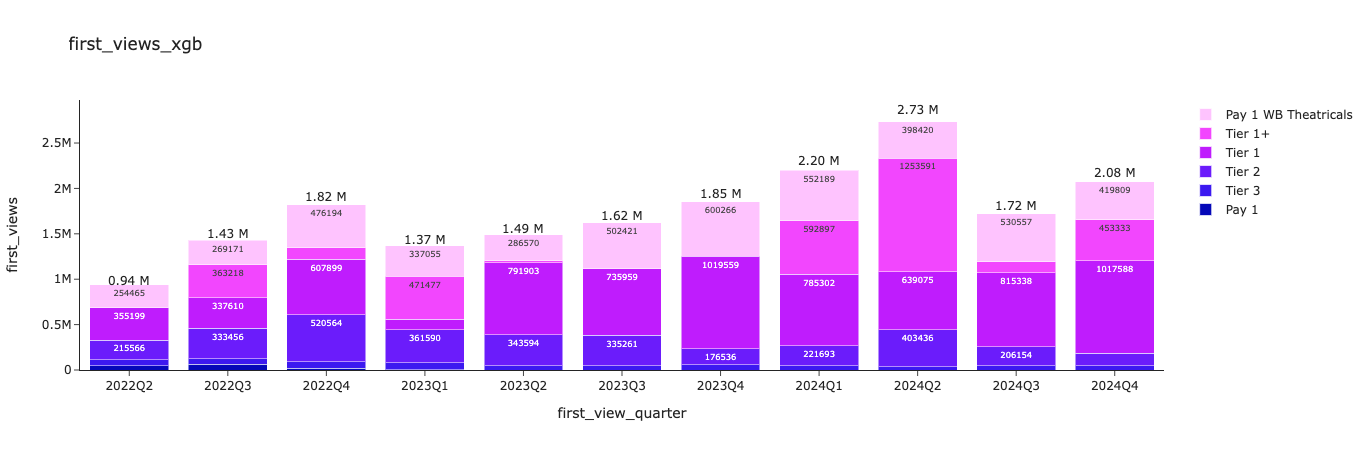

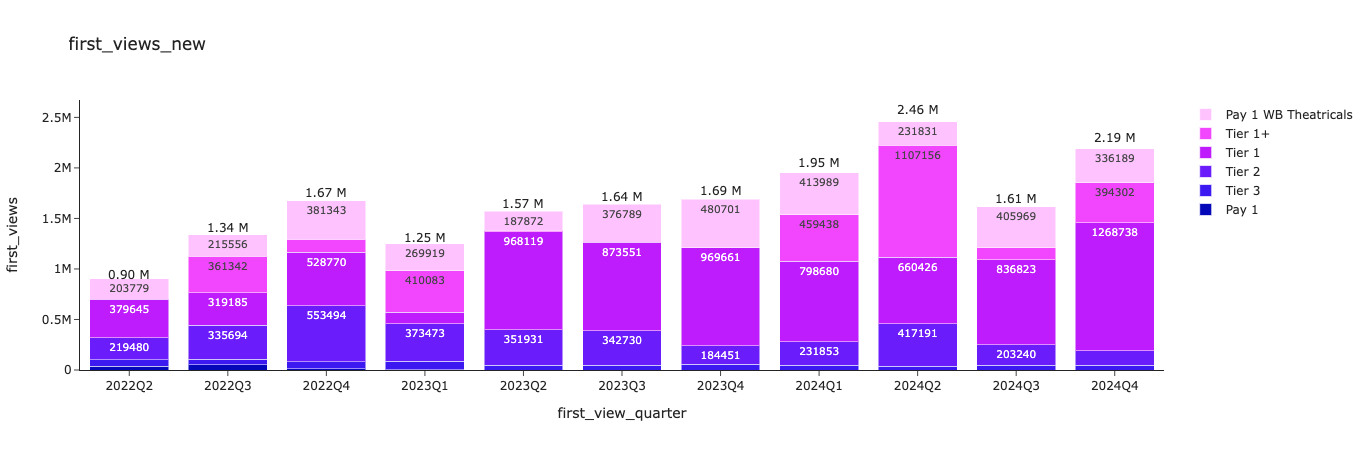

first_view_quarter    2022Q22022Q22022Q22022Q22022Q22022Q32022Q32022...
tier_cat              Pay 1Pay 1 WB TheatricalsTier 1Tier 2Tier 3Pay...
first_views_xgb                                             1.92472e+07
first_views_new                                              1.8282e+07
pred_diff_million                                              0.965217
pct_pred_diff                                                   5.16405
dtype: object

,first_views_xgb,first_views_new,pred_diff_million,pct_pred_diff
first_view_quarter,,,,
2024Q4,415069.80,437980.60,-0.02,0.03
2023Q2,297779.40,314570.60,-0.02,0.09
2023Q3,404911.50,409808.50,-0.00,0.04
2022Q2,187659.20,180724.40,0.01,0.10
2022Q3,238278.50,223434.33,0.01,0.11
2023Q1,228090.17,208443.17,0.02,0.11
2024Q3,344141.80,322676.20,0.02,0.06
2022Q4,303751.67,279103.83,0.02,0.11
2023Q4,463242.75,422632.75,0.04,0.07


,first_views_xgb,first_views_new,pred_diff_million,pct_pred_diff
tier_cat,,,,
Tier 1,656715.18,701458.82,-0.04,-0.03
Tier 2,296124.27,305367.91,-0.01,-0.03
Tier 3,54811.64,55044.91,-0.00,-0.00
Pay 1,33539.50,25440.75,0.01,0.32
Tier 1+,425224.12,374465.62,0.05,0.11
Pay 1 WB Theatricals,420647.00,318539.73,0.10,0.34


first_views_xgb  first_views_new  \
tier_cat             category                                                   
Tier 1               Scripted Comedy Series         57696.12        108538.38   
                     Scripted Drama Series         325482.42        360987.42   
Tier 2               Scripted Drama Series          65478.50         73131.50   
                     Scripted Features              65205.00         70015.45   
Tier 3               Unscripted Series               8525.00         10233.25   
                     Docu-Series                     7886.17          9141.67   
Tier 2               Scripted Comedy Series         45372.73         46296.18   
                     Docu-Series                    21075.55         21977.18   
Tier 3               Kids & Family                   4528.25          4913.42   
                     International                    529.18           687.36   
Tier 2               International                   3924.00          3997.75   
Tier 3               Scripted Drama Series           5666.12          5638.88   
                     Specials                        4489.20          4003.80   
                     Scripted Comedy Series          9408.00          8874.33   
                     Scripted Features               4182.50          3351.00   
Tier 2               Kids & Family                   3675.00          2799.50   
                     Unscripted Series              19820.91         17788.73   
Tier 3               Documentary Features           13749.25         11365.67   
Tier 2               Documentary Features           69561.64         66723.73   
Pay 1                Pay1                           33539.50         25440.75   
Tier 1               Scripted Features             246405.83        218121.67   
Tier 1+              Scripted Drama Series         382207.78        336538.22   
Pay 1 WB Theatricals Pay 1 WB Theatricals          389061.92        294772.67   

                                             pred_diff_million  pct_pred_diff  
tier_cat             category                                                  
Tier 1               Scripted Comedy Series              -0.05           0.14  
                     Scripted Drama Series               -0.04          -0.09  
Tier 2               Scripted Drama Series               -0.01          -0.10  
                     Scripted Features                   -0.00          -0.07  
Tier 3               Unscripted Series                   -0.00          -0.17  
                     Docu-Series                         -0.00          -0.14  
Tier 2               Scripted Comedy Series              -0.00          -0.02  
                     Docu-Series                         -0.00          -0.04  
Tier 3               Kids & Family                       -0.00          -0.10  
                     International                       -0.00          -0.22  
Tier 2               International                       -0.00          -0.02  
Tier 3               Scripted Drama Series                0.00           0.00  
                     Specials                             0.00           0.12  
                     Scripted Comedy Series               0.00           0.06  
                     Scripted Features                    0.00           0.25  
Tier 2               Kids & Family                        0.00           0.31  
                     Unscripted Series                    0.00           0.11  
Tier 3               Documentary Features                 0.00           0.26  
Tier 2               Documentary Features                 0.00           0.04  
Pay 1                Pay1                                 0.01           0.32  
Tier 1               Scripted Features                    0.03           0.13  
Tier 1+              Scripted Drama Series                0.05           0.12  
Pay 1 WB Theatricals Pay 1 WB Theatricals                 0.09           0.33

tier_cat             Pay 1Pay 1 WB TheatricalsTier 1Tier 1Tier 2Tie...
category             Pay1Pay 1 WB TheatricalsScripted Drama SeriesS...
first_views_xgb                                            1.94477e+07
first_views_new                                            1.84716e+07
pred_diff_million                                             0.976096
pct_pred_diff                                                  7.74376
dtype: object


,tier_cat,title_name,tier,season_number,category,effective_start_date,prequel_count,prequel_featured_count,page_views,page_views_s,prequel_featured_count_s,first_views_xgb,first_views_new
99,Tier 1+,DCU Green Lantern,0,1,Scripted Drama Series,2024-03-14,-1.0,-1.0,-1,100000,9.0,491409.90625,279965.93750
100,Tier 1+,Dunk & Egg,0,1,Scripted Drama Series,2024-02-12,-1.0,-1.0,-1,200000,0.0,491409.90625,427420.53125
104,Tier 1+,The Last Of Us,0,1,Scripted Drama Series,2023-01-15,-1.0,-1.0,-1,200000,0.0,491409.90625,427420.53125
105,Tier 1+,The Last Of Us,0,2,Scripted Drama Series,2024-10-27,-1.0,-1.0,-1,200000,0.0,491409.90625,427420.53125
103,Tier 1+,Sisterhood of Dune,0,1,Scripted Drama Series,2024-04-25,-1.0,-1.0,-1,200000,19.0,491409.90625,488871.75000
101,Tier 1+,House Of The Dragon,0,1,Scripted Drama Series,2022-08-21,-1.0,-1.0,-1,200000,40.0,491409.90625,488871.75000
102,Tier 1+,House Of The Dragon,0,2,Scripted Drama Series,2024-05-12,-1.0,-1.0,-1,200000,40.0,491409.90625,488871.75000


,tier_cat,title_name,tier,season_number,category,effective_start_date,prequel_count,prequel_featured_count,page_views,page_views_s,prequel_featured_count_s,first_views_xgb,first_views_new
87,Tier 1,The Sex Lives of College Girls,1,2,Scripted Comedy Series,2022-11-17,-1.0,-1.0,-1,200000,0.0,92313.812500,55753.035156
89,Tier 1,The Sex Lives of College Girls,1,4,Scripted Comedy Series,2024-11-14,-1.0,-1.0,-1,200000,0.0,92313.812500,55753.035156
88,Tier 1,The Sex Lives of College Girls,1,3,Scripted Comedy Series,2023-11-16,-1.0,-1.0,-1,200000,0.0,92313.812500,55753.035156
34,Pay 1 WB Theatricals,The Last Train To New York,1,0,Pay 1 WB Theatricals,2023-06-05,0.0,0.0,1000,-1,-1.0,155624.781250,57452.046875
37,Pay 1 WB Theatricals,Toto,1,0,Pay 1 WB Theatricals,2024-03-18,0.0,0.0,1000,-1,-1.0,155624.781250,57452.046875
35,Pay 1 WB Theatricals,The Lord Of The Rings: The War Of The Rohirrim,1,0,Pay 1 WB Theatricals,2024-05-27,0.0,0.0,1000,-1,-1.0,155624.781250,57452.046875
60,Tier 1,Gossip Girl,1,2,Scripted Drama Series,2022-11-10,-1.0,-1.0,-1,100000,40.0,134682.390625,94545.875000
75,Tier 1,Pretty Little Liars: Original Sin,1,1,Scripted Drama Series,2022-07-07,-1.0,-1.0,-1,100000,40.0,134682.390625,94545.875000
77,Tier 1,Pretty Little Liars: Original Sin / More,1,1,Scripted Drama Series,2023-10-12,-1.0,-1.0,-1,100000,40.0,134682.390625,94545.875000
20,Pay 1 WB Theatricals,Black Adam,1,0,Pay 1 WB Theatricals,2022-12-05,0.0,0.0,100000,-1,-1.0,155624.781250,124626.570312


In [16]:
def get_filtered_first_views_future(df_in, offset, grpby_title, first_view_date_col):
    ## Get predictions according to the offset 
    ## e.g. How good are we in predicting next 3 months? 
    df_in['pred_date'] = pd.to_datetime(df_in['pred_date'])
    df_in[first_view_date_col] = pd.to_datetime(df_in[first_view_date_col])
    df_in['first_view_month'] = df_in[first_view_date_col].dt.to_period('M').dt.to_timestamp()

    ## select rows where first_view_months are within offset months + prediction date
#     df_in = df_in[(df_in['first_view_month']<= df_in['pred_date'] + pd.DateOffset(months=offset))]  
    return df_in

def get_agg_first_views(df_in, agg_col, grpby_title, first_view_date_col, first_view_col):
    grpby_title_agg = grpby_title + [agg_col]
    df_in[first_view_date_col] = pd.to_datetime(df_in[first_view_date_col])
    df_in['first_view_quarter'] = df_in[first_view_date_col].dt.to_period("Q").dt.to_timestamp()   
    df_in['first_view_month'] = df_in[first_view_date_col].dt.to_period('M').dt.to_timestamp()
    df_in = df_in[grpby_title_agg + first_view_col].groupby(by=grpby_title_agg).sum().reset_index()
    return df_in

def get_tier_cat(df_pred_future_fv):
    ### Get tier_cat 
    f_pay = (df_pred_future_fv['category']=='Pay1')
    f_payt = (df_pred_future_fv['category']=='Pay 1 WB Theatricals')
    f_popcorn = (df_pred_future_fv['category']=='Popcorn')
    f_t0 = (df_pred_future_fv['tier']==0) & ~(df_pred_future_fv['category'].isin(['Pay1','Popcorn','Pay 1 WB Theatricals']))
    f_t1 = (df_pred_future_fv['tier']==1) & ~(df_pred_future_fv['category'].isin(['Pay1','Popcorn','Pay 1 WB Theatricals']))
    f_t2 = (df_pred_future_fv['tier']==2) & ~(df_pred_future_fv['category'].isin(['Pay1','Popcorn','Pay 1 WB Theatricals']))
    f_t3 = (df_pred_future_fv['tier']==3) & ~(df_pred_future_fv['category'].isin(['Pay1','Popcorn','Pay 1 WB Theatricals']))

    df_pred_future_fv['tier_cat'] = None
    # df_pred_future_fv.loc[f_payt, 'tier_cat'] = 'Pay1 Theatrical'
    df_pred_future_fv.loc[f_pay, 'tier_cat'] = 'Pay 1'
    df_pred_future_fv.loc[f_payt, 'tier_cat'] = 'Pay 1 WB Theatricals'
    df_pred_future_fv.loc[f_popcorn, 'tier_cat'] = 'Popcorn'
    df_pred_future_fv.loc[f_t0, 'tier_cat'] = 'Tier 1+'
    df_pred_future_fv.loc[f_t1, 'tier_cat'] = 'Tier 1'
    df_pred_future_fv.loc[f_t2, 'tier_cat'] = 'Tier 2'
    df_pred_future_fv.loc[f_t3, 'tier_cat'] = 'Tier 3'
    return df_pred_future_fv

def get_stacked_plot(df_plt, var):
    fig = go.Figure()
    tier_cat_list = ['Pay 1', 'Tier 3','Tier 2','Tier 1','Tier 1+','Popcorn','Pay 1 WB Theatricals',]  ## px.colors.sequential.Plotly3

    for r, c in zip(tier_cat_list,  ['#0508b8','#3c19f0','#6b1cfb','#bf1cfd','#f246fe','#fe88fc','#fec3fe']):
        plot_df = df_plt[df_plt.tier_cat == r]
        fig.add_trace(
            go.Bar(x=plot_df.first_view_quarter, y=plot_df[var], name=r, marker_color=c, 
                   text=plot_df[var], textposition='inside', textangle=0) ,
        )

    annotation=[]    
    quarters=df_plt.first_view_quarter.unique().tolist()
    models = ['xgb','rwm']
    for q in quarters:#, m in itertools.product(quarters, models):
        plot_df = df_plt[(df_plt.first_view_quarter==q)]    
        dic= {"x":q, "y": plot_df[var].sum()*1.05,
                     "text": f'{plot_df[var].sum()/1000000:.2f} M', 
                     "showarrow": False} 
        annotation.append(dic)


    fig.update_layout(
        template="simple_white",
        title=var,
        xaxis=dict(title_text="first_view_quarter"),
        yaxis=dict(title_text="first_views"),
        barmode="stack",
        uniformtext_minsize=8, 
        uniformtext_mode='hide',
        annotations=annotation
    )

    py.offline.iplot(fig)
    return 



df_rwm = df_pred_decay_n.copy()
df_rwm['first_views_new'] = df_rwm['first_views_pred_decay'] 

offset=2
agg_var = 'first_view_month'
df_pred_decay_o['content_category']=0

grpby_title= ['title_name','tier','tier_adj','season_number','category', 'content_category', 'effective_start_date',]
df_decay_future = get_filtered_first_views_future(df_pred_decay_o, offset, grpby_title, 'request_date')
df_pred_future_fv_xgb = get_agg_first_views(df_decay_future,  agg_var,grpby_title,'request_date', [f'first_views_pred_decay'])
df_pred_future_fv_xgb['first_view_quarter'] = df_pred_future_fv_xgb['first_view_month'].dt.to_period('Q')
df_pred_future_fv_xgb = get_tier_cat(df_pred_future_fv_xgb)
df_pred_future_fv_xgb['model'] = 'xgb'
df_pred_future_fv_xgb = df_pred_future_fv_xgb.rename(columns={'first_views_pred_decay':'first_views_xgb'})

grpby_title_rwm= ['title_name','tier','season_number','category','effective_start_date','prequel_count','prequel_featured_count','page_views','page_views_s']+feature_other
# df_decay_future_rwm = get_filtered_first_views_future(df_pred_decay_future, offset, grpby_title, 'request_date')
df_pred_future_fv_rwm = get_agg_first_views(df_rwm, agg_var, grpby_title_rwm,  'request_date', ['first_views_new'])
df_pred_future_fv_rwm['first_view_quarter'] = df_pred_future_fv_rwm['first_view_month'].dt.to_period('Q')
df_pred_future_fv_rwm['tier'] = df_pred_future_fv_rwm['tier'].astype(int)
df_pred_future_fv_rwm = get_tier_cat(df_pred_future_fv_rwm)
df_pred_future_fv_rwm['model'] = 'new'
df_pred_future_fv_rwm = df_pred_future_fv_rwm.rename(columns={'first_views_new':'first_views_new'})


print(df_pred_future_fv_xgb[(df_pred_future_fv_xgb['first_view_quarter']>'2021Q4') & (df_pred_future_fv_xgb['first_view_quarter']<'2025Q1')].title_name.nunique())
print(df_pred_future_fv_rwm[(df_pred_future_fv_rwm['first_view_quarter']>'2021Q4') & (df_pred_future_fv_rwm['first_view_quarter']<'2025Q1')].title_name.nunique())

## Groupby tier_cat quarter 
grpby_quarter= ['first_view_quarter','tier_cat']
df_pred_future_fv = df_pred_future_fv_rwm.merge(df_pred_future_fv_xgb, on=['title_name', 'tier', 'tier_cat', 'season_number', 'category', 'first_view_month','first_view_quarter', 'effective_start_date', 'tier_cat'], suffixes=['_rwm','_xgb'], how='left')
df_pred_future_fv = df_pred_future_fv[['title_name', 'tier_cat', 'tier', 'tier_adj', 'season_number', 'content_category', 'category',
       'effective_start_date',  'first_view_month', 'first_view_quarter', 
       'prequel_count', 'prequel_featured_count','page_views', 'page_views_s', 'first_views_xgb','first_views_new']+feature_other]

# df_rwm_future_grp = pd.read_csv('s3://datascience-hbo-users/users/tjung/psi/fv_rwm_dash.csv')


## Group by title 
df_pred_future_fv_title = df_pred_future_fv.groupby(by=['tier_cat']+ grpby_title_rwm)[['first_views_xgb','first_views_new']].sum().reset_index()

## Group by quarter
df_plt = df_pred_future_fv.groupby(by=['first_view_quarter'])[['first_views_xgb','first_views_new']].sum().reset_index().round()
df_plt['pred_diff_million'] = (df_plt['first_views_xgb']-df_plt['first_views_new'])/1000000
df_plt['pct_pred_diff'] = (df_plt['first_views_xgb']-df_plt['first_views_new'])/df_plt['first_views_new']
display(df_plt.sort_values(by='pred_diff_million', ascending=True).round(2))
display(df_plt.mean())


## Group by quarter - tier_cat
df_pred_future_fv_quarter = df_pred_future_fv.groupby(by=grpby_quarter)[['first_views_xgb','first_views_new']].sum().reset_index()
df_plt = df_pred_future_fv_quarter.round()
df_plt = df_plt[(df_plt['first_view_quarter']>'2021Q4') & (df_plt['first_view_quarter']<'2025Q1')]
df_plt['first_view_quarter'] = df_plt['first_view_quarter'].astype(str)
get_stacked_plot(df_plt, 'first_views_xgb')
get_stacked_plot(df_plt, 'first_views_new')

df_plt['pred_diff_million'] = (df_plt['first_views_xgb']-df_plt['first_views_new'])/1000000
df_plt['pct_pred_diff'] = (df_plt['first_views_xgb']-df_plt['first_views_new'])/df_plt['first_views_new']
display(df_plt.sum())
display(df_plt.groupby(by=['first_view_quarter']).mean().sort_values(by='pred_diff_million', ascending=True).round(2))
display(df_plt.groupby(by=['tier_cat']).mean().sort_values(by='pred_diff_million', ascending=True).round(2))

## Group by quarter- tier_cat- category 
df_plt = df_pred_future_fv.groupby(by=['first_view_quarter','tier_cat','category'])[['first_views_xgb','first_views_new']].sum().reset_index().round()
df_plt['pred_diff_million'] = (df_plt['first_views_xgb']-df_plt['first_views_new'])/1000000
df_plt['pct_pred_diff'] = (df_plt['first_views_xgb']-df_plt['first_views_new'])/df_plt['first_views_new']
display(df_plt.groupby(by=['tier_cat','category']).mean().sort_values(by='pred_diff_million', ascending=True).round(2))
print(df_plt.sum())

display(df_pred_future_fv_title[df_pred_future_fv_title.tier==0].sort_values(by='first_views_new'))
display(df_pred_future_fv_title[df_pred_future_fv_title.tier==1].sort_values(by='first_views_new'))


457
433


,first_view_quarter,first_views_xgb,first_views_new,pred_diff_million,pct_pred_diff
6,2023Q4,1249945.0,1580332.0,-0.33,-0.21
5,2023Q3,1282732.0,1589930.0,-0.31,-0.19
1,2022Q3,1288036.0,1565583.0,-0.28,-0.18
4,2023Q2,1173490.0,1392508.0,-0.22,-0.16
9,2024Q3,1036840.0,1214281.0,-0.18,-0.15
2,2022Q4,1598571.0,1768036.0,-0.17,-0.10
0,2022Q2,784348.0,924540.0,-0.14,-0.15
7,2024Q1,1716190.0,1702027.0,0.01,0.01
8,2024Q2,2289131.0,2271150.0,0.02,0.01
11,2025Q1,71819.0,31485.0,0.04,1.28


first_views_xgb      1.231766e+06
first_views_new      1.329052e+06
pred_diff_million   -9.728600e-02
pct_pred_diff        4.805766e-02
dtype: float64

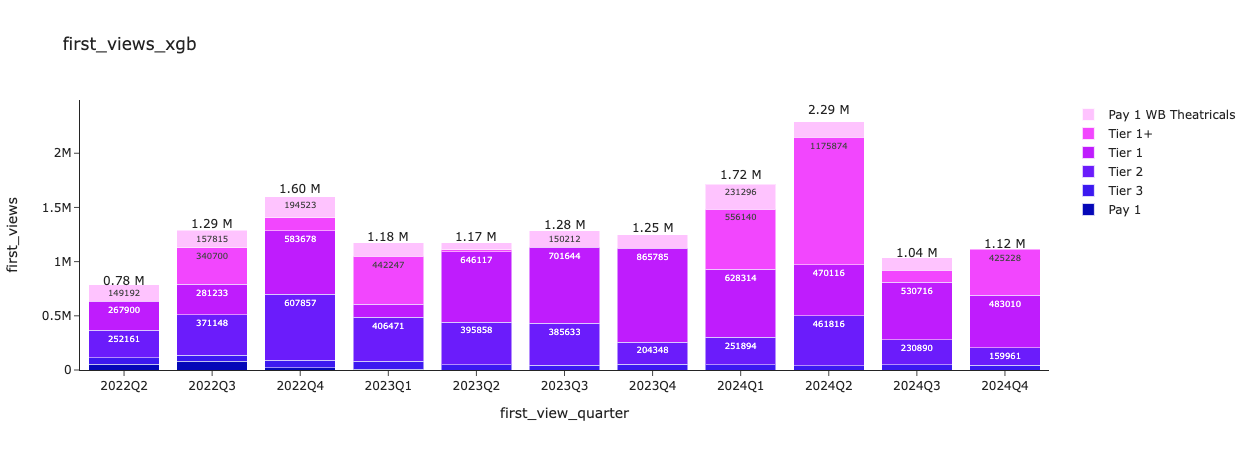

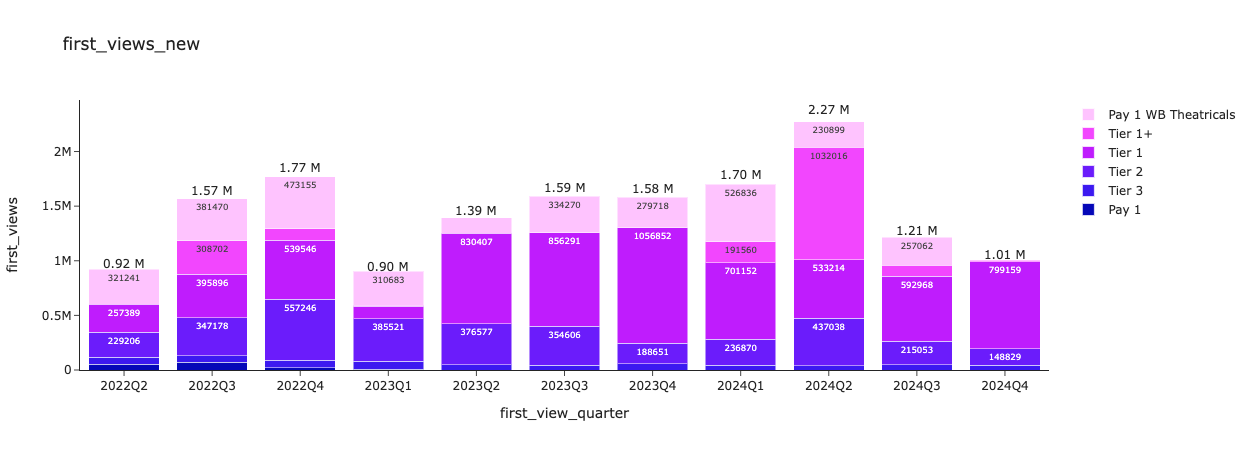

first_view_quarter    2022Q22022Q22022Q22022Q22022Q22022Q32022Q32022...
tier_cat              Pay 1Pay 1 WB TheatricalsTier 1Tier 2Tier 3Pay...
first_views_xgb                                             1.47094e+07
first_views_new                                             1.59171e+07
pred_diff_million                                              -1.20777
pct_pred_diff                                                   120.854
dtype: object

,first_views_xgb,first_views_new,pred_diff_million,pct_pred_diff
first_view_quarter,,,,
2023Q4,312486.25,395083.25,-0.08,-0.17
2023Q3,320683.00,397482.75,-0.08,-0.16
2022Q3,214672.83,260930.33,-0.05,-0.11
2023Q2,234697.80,278501.60,-0.04,8.18
2024Q3,207368.00,242856.20,-0.04,-0.10
2022Q4,266428.67,294672.67,-0.03,-0.04
2022Q2,156869.80,184908.00,-0.03,-0.08
2024Q1,343237.80,340405.40,0.00,0.27
2024Q2,457826.00,454230.00,0.00,-0.05


,first_views_xgb,first_views_new,pred_diff_million,pct_pred_diff
tier_cat,,,,
Pay 1 WB Theatricals,132716.36,296122.09,-0.16,-0.55
Tier 1,506858.73,607041.09,-0.10,-0.13
Tier 3,54002.00,53847.73,0.00,0.01
Pay 1,40274.00,37486.50,0.00,0.07
Tier 2,338912.45,316070.45,0.02,0.07
Tier 1+,398862.00,220412.75,0.18,15.89


first_views_xgb  first_views_new  \
tier_cat             category                                                   
Pay 1 WB Theatricals Pay 1 WB Theatricals          132716.36        296122.09   
Tier 1               Scripted Comedy Series         52291.25        110161.62   
                     Scripted Features             207273.67        242329.33   
                     Scripted Drama Series         300388.73        329497.64   
Tier 2               Scripted Comedy Series         50921.45         58406.82   
                     Docu-Series                    23240.36         25162.27   
Tier 3               Scripted Drama Series           3999.25          5345.88   
                     Scripted Comedy Series          7435.25          8614.92   
                     Unscripted Series               7435.25          8614.83   
                     Docu-Series                     7712.17          8878.17   
Tier 2               Kids & Family                   2972.60          4033.80   
Tier 3               Scripted Features               2746.50          3372.00   
Tier 2               International                   3773.25          3820.25   
Tier 3               International                    763.82           803.09   
                     Specials                        5289.60          4301.40   
Tier 2               Unscripted Series              19384.18         18263.73   
                     Scripted Features              70857.45         69724.00   
Tier 3               Kids & Family                   6290.75          4378.08   
                     Documentary Features           15346.58         12876.25   
Pay 1                Pay1                           40274.00         37486.50   
Tier 2               Scripted Drama Series          82692.58         70964.75   
                     Documentary Features           81544.82         63267.45   
Tier 1+              Scripted Drama Series         358512.56        196015.67   

                                             pred_diff_million  pct_pred_diff  
tier_cat             category                                                  
Pay 1 WB Theatricals Pay 1 WB Theatricals                -0.16          -0.55  
Tier 1               Scripted Comedy Series              -0.06          -0.00  
                     Scripted Features                   -0.04          -0.13  
                     Scripted Drama Series               -0.03          -0.04  
Tier 2               Scripted Comedy Series              -0.01          -0.13  
                     Docu-Series                         -0.00          -0.08  
Tier 3               Scripted Drama Series               -0.00          -0.25  
                     Scripted Comedy Series              -0.00          -0.14  
                     Unscripted Series                   -0.00          -0.14  
                     Docu-Series                         -0.00          -0.13  
Tier 2               Kids & Family                       -0.00          -0.26  
Tier 3               Scripted Features                   -0.00          -0.18  
Tier 2               International                       -0.00          -0.01  
Tier 3               International                       -0.00          -0.05  
                     Specials                             0.00           0.23  
Tier 2               Unscripted Series                    0.00           0.06  
                     Scripted Features                    0.00           0.02  
Tier 3               Kids & Family                        0.00           0.51  
                     Documentary Features                 0.00           0.19  
Pay 1                Pay1                                 0.00           0.07  
Tier 2               Scripted Drama Series                0.01           0.17  
                     Documentary Features                 0.02           0.29  
Tier 1+              Scripted Drama Series                0.16          18.74

tier_cat             Pay 1Pay 1 WB TheatricalsTier 1Tier 2Tier 2Tie...
category             Pay1Pay 1 WB TheatricalsScripted Drama SeriesD...
first_views_xgb                                            1.47812e+07
first_views_new                                            1.59486e+07
pred_diff_million                                             -1.16743
pct_pred_diff                                                  164.195
dtype: object


,tier_cat,title_name,tier,tier_adj,season_number,category,content_category,effective_start_date,prequel_count,prequel_featured_count,page_views,page_views_s,prequel_featured_count_s,first_views_xgb,first_views_new
80,Tier 1+,The Last Of Us,0,0,2,Scripted Drama Series,0,2024-10-27,0.0,0.0,0.0,100000.0,5.0,460944.875,10821.616211
75,Tier 1+,Dunk & Egg,0,0,1,Scripted Drama Series,0,2024-02-12,0.0,0.0,0.0,100000.0,5.0,460944.875,10821.616211
79,Tier 1+,The Last Of Us,0,0,1,Scripted Drama Series,0,2023-01-15,0.0,0.0,0.0,100000.0,5.0,460944.875,10821.616211
78,Tier 1+,Sisterhood of Dune,0,0,1,Scripted Drama Series,0,2024-04-25,0.0,0.0,0.0,100000.0,15.0,460944.875,417653.593750
76,Tier 1+,House Of The Dragon,0,0,1,Scripted Drama Series,0,2022-08-21,0.0,0.0,0.0,100000.0,15.0,460944.875,417653.593750
77,Tier 1+,House Of The Dragon,0,0,2,Scripted Drama Series,0,2024-05-12,0.0,0.0,0.0,100000.0,15.0,460944.875,417653.593750
74,Tier 1+,DCU Green Lantern,0,0,1,Scripted Drama Series,0,2024-03-14,0.0,0.0,0.0,83019.0,9.0,460944.875,478715.250000


,tier_cat,title_name,tier,tier_adj,season_number,category,content_category,effective_start_date,prequel_count,prequel_featured_count,page_views,page_views_s,prequel_featured_count_s,first_views_xgb,first_views_new
65,Tier 1,The Sex Lives of College Girls,1,1,4,Scripted Comedy Series,0,2024-11-14,0.0,0.0,0.0,100000.0,0.0,83665.765625,58105.164062
63,Tier 1,The Sex Lives of College Girls,1,1,2,Scripted Comedy Series,0,2022-11-17,0.0,0.0,0.0,100000.0,0.0,83665.765625,58105.164062
64,Tier 1,The Sex Lives of College Girls,1,1,3,Scripted Comedy Series,0,2023-11-16,0.0,0.0,0.0,100000.0,0.0,83665.765625,58105.164062
44,Tier 1,Gossip Girl,1,1,2,Scripted Drama Series,0,2022-11-10,0.0,0.0,0.0,32212.0,15.0,137678.156250,95878.914062
71,Tier 1,Winning Time: The Rise Of The Lakers Dynasty,1,1,2,Scripted Drama Series,0,2023-07-16,0.0,0.0,0.0,100000.0,0.0,137678.156250,123560.765625
49,Tier 1,Love & Death,1,1,1,Scripted Drama Series,0,2022-10-20,0.0,0.0,0.0,100000.0,0.0,137678.156250,123560.765625
45,Tier 1,JJ Abrams / Duster,1,1,1,Scripted Drama Series,0,2023-05-18,0.0,0.0,0.0,39363.0,0.0,137678.156250,123560.765625
33,Tier 1,A Time For Mercy,1,1,1,Scripted Drama Series,0,2024-03-03,0.0,0.0,0.0,100000.0,0.0,137678.156250,123560.765625
62,Tier 1,The Girls on the Bus,1,1,2,Scripted Drama Series,0,2023-08-31,0.0,0.0,0.0,16135.0,0.0,137678.156250,123560.765625
72,Tier 1,Winning Time: The Rise Of The Lakers Dynasty,1,1,3,Scripted Drama Series,0,2024-09-22,0.0,0.0,0.0,100000.0,0.0,137678.156250,123560.765625


457
433


,first_view_quarter,first_views_xgb,first_views_new,pred_diff_million,pct_pred_diff
1,2022Q3,1288036.0,1655987.0,-0.37,-0.22
6,2023Q4,1249945.0,1543736.0,-0.29,-0.19
9,2024Q3,1036840.0,1158645.0,-0.12,-0.11
0,2022Q2,784348.0,830235.0,-0.05,-0.06
2,2022Q4,1598571.0,1578978.0,0.02,0.01
11,2025Q1,71819.0,30910.0,0.04,1.32
5,2023Q3,1282732.0,1215432.0,0.07,0.06
4,2023Q2,1173490.0,1084529.0,0.09,0.08
8,2024Q2,2289131.0,2067804.0,0.22,0.11
10,2024Q4,1115021.0,881477.0,0.23,0.26


first_views_xgb      1.231766e+06
first_views_new      1.193135e+06
pred_diff_million    3.863117e-02
pct_pred_diff        1.562014e-01
dtype: float64

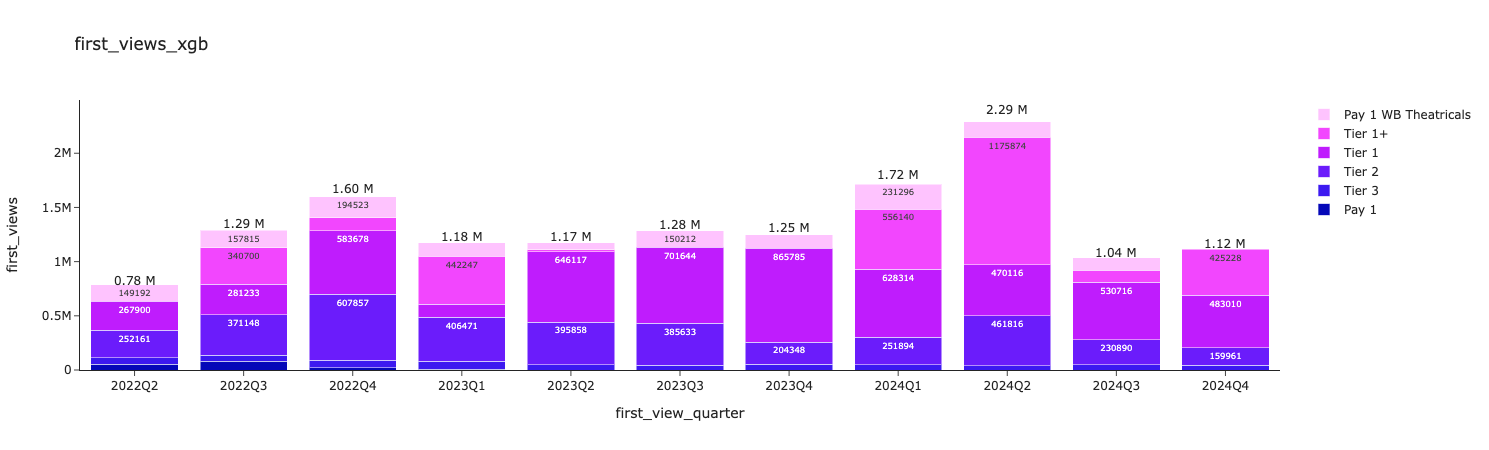

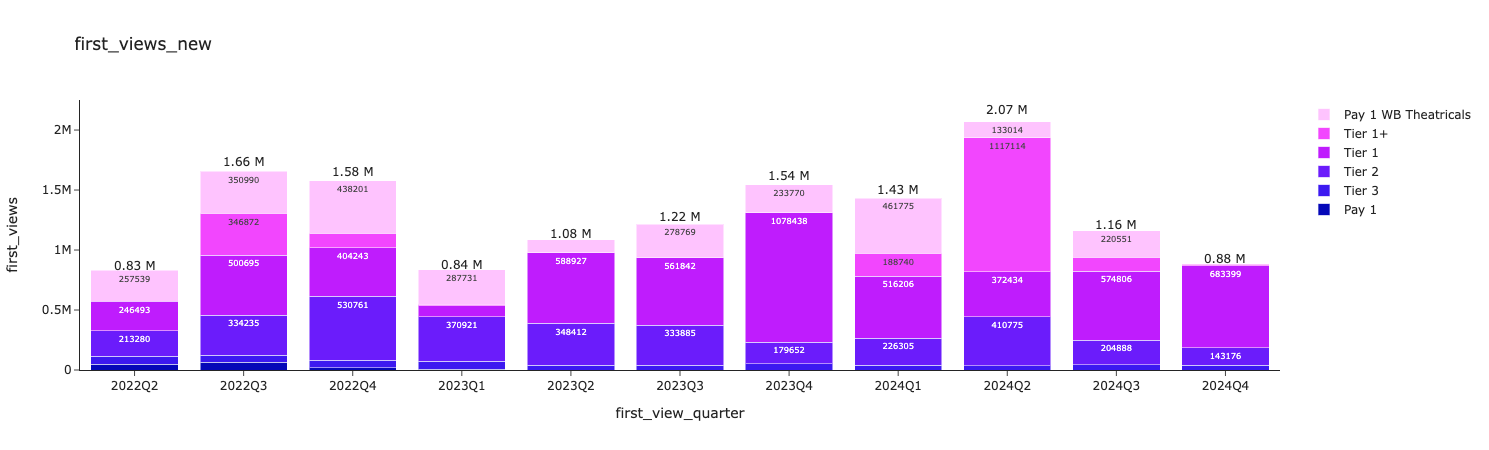

first_view_quarter    2022Q22022Q22022Q22022Q22022Q22022Q32022Q32022...
tier_cat              Pay 1Pay 1 WB TheatricalsTier 1Tier 2Tier 3Pay...
first_views_xgb                                             1.47094e+07
first_views_new                                             1.42867e+07
pred_diff_million                                              0.422664
pct_pred_diff                                                   115.497
dtype: object

,first_views_xgb,first_views_new,pred_diff_million,pct_pred_diff
first_view_quarter,,,,
2023Q4,312486.25,385934.00,-0.07,-0.12
2022Q3,214672.83,275998.00,-0.06,-0.11
2024Q3,207368.00,231729.00,-0.02,-0.07
2022Q2,156869.80,166047.00,-0.01,-0.01
2022Q4,266428.67,263163.17,0.00,0.05
2023Q3,320683.00,303857.75,0.02,0.01
2023Q2,234697.80,216905.80,0.02,7.64
2024Q2,457826.00,413560.80,0.04,0.14
2024Q4,223004.00,176295.40,0.05,7.51


,first_views_xgb,first_views_new,pred_diff_million,pct_pred_diff
tier_cat,,,,
Pay 1 WB Theatricals,132716.36,251941.36,-0.12,-0.44
Tier 1,506858.73,511188.18,-0.00,0.05
Tier 3,54002.00,50002.55,0.00,0.09
Pay 1,40274.00,33605.75,0.01,0.20
Tier 2,338912.45,299662.73,0.04,0.13
Tier 1+,398862.00,238943.38,0.16,14.57


first_views_xgb  first_views_new  \
tier_cat             category                                                   
Pay 1 WB Theatricals Pay 1 WB Theatricals          132716.36        251941.36   
Tier 1               Scripted Comedy Series         52291.25         87880.50   
Tier 3               Scripted Drama Series           3999.25          6659.62   
                     Scripted Features               2746.50          3826.50   
Tier 2               Kids & Family                   2972.60          3691.60   
Tier 3               Docu-Series                     7712.17          7968.25   
Tier 2               Docu-Series                    23240.36         23453.45   
Tier 3               International                    763.82           811.82   
                     Scripted Comedy Series          7435.25          7473.25   
Tier 2               International                   3773.25          3658.00   
Tier 3               Unscripted Series               7435.25          6906.08   
                     Specials                        5289.60          4630.20   
Tier 2               Scripted Features              70857.45         69590.27   
                     Unscripted Series              19384.18         18115.91   
                     Scripted Comedy Series         50921.45         49646.91   
Tier 3               Kids & Family                   6290.75          5009.75   
Tier 1               Scripted Drama Series         300388.73        298641.18   
Tier 3               Documentary Features           15346.58         11371.00   
Pay 1                Pay1                           40274.00         33605.75   
Tier 2               Scripted Drama Series          82692.58         65319.50   
                     Documentary Features           81544.82         64065.36   
Tier 1               Scripted Features             207273.67        182730.00   
Tier 1+              Scripted Drama Series         358512.56        212495.33   

                                             pred_diff_million  pct_pred_diff  
tier_cat             category                                                  
Pay 1 WB Theatricals Pay 1 WB Theatricals                -0.12          -0.44  
Tier 1               Scripted Comedy Series              -0.04          -0.01  
Tier 3               Scripted Drama Series               -0.00          -0.40  
                     Scripted Features                   -0.00          -0.28  
Tier 2               Kids & Family                       -0.00          -0.19  
Tier 3               Docu-Series                         -0.00          -0.03  
Tier 2               Docu-Series                         -0.00          -0.01  
Tier 3               International                       -0.00          -0.06  
                     Scripted Comedy Series              -0.00          -0.01  
Tier 2               International                        0.00           0.03  
Tier 3               Unscripted Series                    0.00           0.08  
                     Specials                             0.00           0.14  
Tier 2               Scripted Features                    0.00           0.02  
                     Unscripted Series                    0.00           0.07  
                     Scripted Comedy Series               0.00           0.03  
Tier 3               Kids & Family                        0.00           0.24  
Tier 1               Scripted Drama Series                0.00           0.29  
Tier 3               Documentary Features                 0.00           0.34  
Pay 1                Pay1                                 0.01           0.20  
Tier 2               Scripted Drama Series                0.02           0.27  
                     Documentary Features                 0.02           0.27  
Tier 1               Scripted Features                    0.02           0.21  
Tier 1+              Scripted Drama Series                0.15          17.19

tier_cat             Pay 1Pay 1 WB TheatricalsTier 1Tier 2Tier 2Tie...
category             Pay1Pay 1 WB TheatricalsScripted Drama SeriesD...
first_views_xgb                                            1.47812e+07
first_views_new                                            1.43176e+07
pred_diff_million                                             0.463569
pct_pred_diff                                                   164.88
dtype: object


,tier_cat,title_name,tier,tier_adj,season_number,category,content_category,effective_start_date,prequel_count,prequel_featured_count,page_views,page_views_s,prequel_featured_count_s,first_views_xgb,first_views_new
75,Tier 1+,Dunk & Egg,0,0,1,Scripted Drama Series,0,2024-02-12,0.0,0.0,0.0,100000.0,5.0,460944.875,11760.304687
79,Tier 1+,The Last Of Us,0,0,1,Scripted Drama Series,0,2023-01-15,0.0,0.0,0.0,100000.0,5.0,460944.875,11760.304687
80,Tier 1+,The Last Of Us,0,0,2,Scripted Drama Series,0,2024-10-27,0.0,0.0,0.0,100000.0,5.0,460944.875,11760.304688
76,Tier 1+,House Of The Dragon,0,0,1,Scripted Drama Series,0,2022-08-21,0.0,0.0,0.0,100000.0,30.0,460944.875,469294.437500
74,Tier 1+,DCU Green Lantern,0,0,1,Scripted Drama Series,0,2024-03-14,0.0,0.0,0.0,83019.0,9.0,460944.875,469294.437500
78,Tier 1+,Sisterhood of Dune,0,0,1,Scripted Drama Series,0,2024-04-25,0.0,0.0,0.0,100000.0,19.0,460944.875,469294.437500
77,Tier 1+,House Of The Dragon,0,0,2,Scripted Drama Series,0,2024-05-12,0.0,0.0,0.0,100000.0,30.0,460944.875,469294.437500


,tier_cat,title_name,tier,tier_adj,season_number,category,content_category,effective_start_date,prequel_count,prequel_featured_count,page_views,page_views_s,prequel_featured_count_s,first_views_xgb,first_views_new
62,Tier 1,The Girls on the Bus,1,1,2,Scripted Drama Series,0,2023-08-31,0.0,0.0,0.0,16135.0,0.0,137678.156250,24638.636719
45,Tier 1,JJ Abrams / Duster,1,1,1,Scripted Drama Series,0,2023-05-18,0.0,0.0,0.0,39363.0,0.0,137678.156250,24638.636719
44,Tier 1,Gossip Girl,1,1,2,Scripted Drama Series,0,2022-11-10,0.0,0.0,0.0,32212.0,30.0,137678.156250,42767.640625
64,Tier 1,The Sex Lives of College Girls,1,1,3,Scripted Comedy Series,0,2023-11-16,0.0,0.0,0.0,100000.0,0.0,83665.765625,61301.851562
65,Tier 1,The Sex Lives of College Girls,1,1,4,Scripted Comedy Series,0,2024-11-14,0.0,0.0,0.0,100000.0,0.0,83665.765625,61301.851562
63,Tier 1,The Sex Lives of College Girls,1,1,2,Scripted Comedy Series,0,2022-11-17,0.0,0.0,0.0,100000.0,0.0,83665.765625,61301.851562
43,Tier 1,Final Destination 6,1,1,0,Scripted Features,0,2023-04-20,0.0,0.0,4896.0,0.0,0.0,143497.109375,64425.515625
30,Pay 1 WB Theatricals,Toto,1,1,0,Pay 1 WB Theatricals,0,2024-03-18,0.0,0.0,7978.0,0.0,0.0,91242.500000,64425.515625
28,Pay 1 WB Theatricals,The Lord Of The Rings: The War Of The Rohirrim,1,1,0,Pay 1 WB Theatricals,0,2024-05-27,0.0,0.0,8426.0,0.0,0.0,91242.500000,64425.515625
73,Tier 1,Wonder Twins,1,1,0,Scripted Features,0,2023-12-14,0.0,0.0,5338.0,0.0,0.0,143497.109375,64425.515625


In [ ]:
def get_agg_first_views(df_in, agg_col, grpby_title, first_view_date_col, first_view_col):
    grpby_title_agg = grpby_title + [agg_col]
    df_in['pred_date'] = pd.to_datetime(df_in['pred_date'])
    df_in[first_view_date_col] = pd.to_datetime(df_in[first_view_date_col])
    df_in['first_view_quarter'] = df_in[first_view_date_col].dt.to_period("Q").dt.to_timestamp()   
    df_in['first_view_month'] = df_in[first_view_date_col].dt.to_period('M').dt.to_timestamp()
    df_in = df_in[grpby_title_agg + first_view_col].groupby(by=grpby_title_agg).sum().reset_index()
    return df_in

def get_tier_cat(df_pred_future_fv):
    ### Get tier_cat 
    f_pay = (df_pred_future_fv['category']=='Pay1')
    f_payt = (df_pred_future_fv['category']=='Pay 1 WB Theatricals')
    f_popcorn = (df_pred_future_fv['category']=='Popcorn')
    f_t0 = (df_pred_future_fv['tier']==0) & ~(df_pred_future_fv['category'].isin(['Pay1','Popcorn','Pay 1 WB Theatricals']))
    f_t1 = (df_pred_future_fv['tier']==1) & ~(df_pred_future_fv['category'].isin(['Pay1','Popcorn','Pay 1 WB Theatricals']))
    f_t2 = (df_pred_future_fv['tier']==2) & ~(df_pred_future_fv['category'].isin(['Pay1','Popcorn','Pay 1 WB Theatricals']))
    f_t3 = (df_pred_future_fv['tier']==3) & ~(df_pred_future_fv['category'].isin(['Pay1','Popcorn','Pay 1 WB Theatricals']))

    df_pred_future_fv['tier_cat'] = None
    # df_pred_future_fv.loc[f_payt, 'tier_cat'] = 'Pay1 Theatrical'
    df_pred_future_fv.loc[f_pay, 'tier_cat'] = 'Pay 1'
    df_pred_future_fv.loc[f_payt, 'tier_cat'] = 'Pay 1 WB Theatricals'
    df_pred_future_fv.loc[f_popcorn, 'tier_cat'] = 'Popcorn'
    df_pred_future_fv.loc[f_t0, 'tier_cat'] = 'Tier 1+'
    df_pred_future_fv.loc[f_t1, 'tier_cat'] = 'Tier 1'
    df_pred_future_fv.loc[f_t2, 'tier_cat'] = 'Tier 2'
    df_pred_future_fv.loc[f_t3, 'tier_cat'] = 'Tier 3'
    return df_pred_future_fv

df_decay_future = df_pred_decay_n.copy()

offset=2
agg_var = 'first_view_month'
df_pred_decay['content_category']=0

grpby_title= ['title_name','tier','tier_adj','season_number','category', 'content_category', 'effective_start_date','prequel_count','prequel_featured_count',]
df_pred_future_fv_xgb = get_agg_first_views(df_decay_future,  agg_var, grpby_title,'request_date', [f'first_views_pred_decay'])
df_pred_future_fv_xgb['first_view_quarter'] = df_pred_future_fv_xgb['first_view_month'].dt.to_period('Q')
df_pred_future_fv_xgb = get_tier_cat(df_pred_future_fv_xgb)
df_pred_future_fv_xgb['model'] = 'xgb'
df_pred_future_fv_xgb = df_pred_future_fv_xgb.rename(columns={'first_views_pred_decay':'first_views_xgb'})
display(df_pred_future_fv_xgb.groupby(by=['first_view_quarter','tier_cat']).sum())

## Title total 
querystr = '''
select * 
from MAX_PROD.CONTENT_ANALYTICS.PSI_DAILY_RW_MEAN_FORECAST
where effective_start_date>='2021-01-01' and effective_start_date<'2022-01-01'
'''

schedule='beta'

cursor_list = ctx.execute_string(
    querystr
    )
df_actual = pd.DataFrame.from_records(cursor_list[-1].fetchall(), columns=[x[0] for x in cursor_list[-1].description])
df_actual.columns= df_actual.columns.str.lower()
df_actual.head(2)

col = ['title_id', 'title_name', 'season_number',
       'content_category', 'content_source', 'program_type', 'category',
       'tier', 'effective_start_date', 'request_date', 
       'days_since_premiere', 'first_views_actual']

df_actual['effective_start_date'] = pd.to_datetime(df_actual['effective_start_date'])
df_actual['request_date'] = pd.to_datetime(df_actual['request_date'])
df_actual['first_views_actual'] = df_actual['predicted_first_views'] 
df_actual.loc[df_actual.effective_start_date<'2021-10-01', 'first_views_actual'] = df_actual['first_views']
